In [357]:
import pandas as pd
import numpy as np

In [358]:
### DEFINE BETA VALUES FOR VDF

vot_growth = 0.014

vot_growth_2 = 0.013

beta_vals = {} # TBD: compute values based on growth

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.13, 3.133, 3.283, 3.286], # [3.820, 3.823, 4.005, 4.009],
    2: [0.715, 0.708, 0.592, 0.708]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2025] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth) ** (2032-2025)

beta_vals[2032] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth_2) ** (2040-2032)

beta_vals[2040] = beta_vals_aux.copy()

beta_vals_aux[1] = beta_vals_aux[1] * (1 + vot_growth_2) ** (2050-2040)

beta_vals[2050] = beta_vals_aux.copy()

beta_vals

{2025:             1      2
 Period              
 AM      3.130  0.715
 MD      3.133  0.708
 PM      3.283  0.592
 NT      3.286  0.708,
 2032:                1      2
 Period                 
 AM      3.449928  0.715
 MD      3.453235  0.708
 PM      3.618567  0.592
 NT      3.621873  0.708,
 2040:                1      2
 Period                 
 AM      3.825477  0.715
 MD      3.829144  0.708
 PM      4.012473  0.592
 NT      4.016140  0.708,
 2050:                1      2
 Period                 
 AM      4.352914  0.715
 MD      4.357086  0.708
 PM      4.565692  0.592
 NT      4.569864  0.708}

In [359]:
### DEFINE LOOKUP TABLE FOR BONUS PER PERIOD

lookup_period_file = r"inputs/LookUp_Period.csv"

lookup_period = pd.read_csv(
    lookup_period_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Clip y reasignar
lookup_period = lookup_period*0

lookup_period

,Bonus/Mile,4 Periods
Period,,
Night,0.0,
AM-Early,0.0,
AM-Peak,0.0,
AM-Shoulder,0.0,
MD,0.0,
PM-Shoulder,0.0,
PM-Peak,0.0,
PM-Late,0.0,


In [ ]:
### DEFINE SEGMENT PARAMETERS
# Default configuration for time periods in traffic data

# TBD: Correctly assess the hard_cap, how does the soft cap work?
# year_soft_cap = [3.6 / 2, 4.2 / 2, 5.15 / 2]

#year_soft_cap = [3.9 / 2, 3.9 / 2, 3.9 / 2]

#TBD: Make this automatically
period_template = [                 # (Period, Hours/Day, Peak/OP, 4Periods tag)
    ("Night",        7, "OP",   "NT"),
    ("AM-Early",     1, "OP",   "AM"),
    ("AM-Peak",      3, "Peak", "AM"),
    ("AM-Shoulder",  1, "OP",   "AM"),
    ("MD",           5, "OP",   "MD"),
    ("PM-Shoulder",  1, "OP",   "PM"),
    ("PM-Peak",      3, "Peak", "PM"),
    ("PM-Late",      3, "OP",   "PM"),
]

rows = []
years = [2025, 2032, 2040, 2050]

# Default time periods list (for reference)
default_time_periods = [
    "Night",
    "AM-Early",
    "AM-Peak",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak",
    "PM-Late"
]

# Create the base scenario: hour -> time period mapping
# hour_to_period = {
#     0: "Night",
#     1: "Night",
#     2: "Night",
#     3: "Night",
#     4: "Night",
#     5: "AM-Early",
#     6: "AM-Peak",
#     7: "AM-Shoulder",
#     8: "AM-Shoulder",
#     9: "AM-Shoulder",
#     10: "MD",
#     11: "MD",
#     12: "MD",
#     13: "MD",
#     14: "PM-Shoulder",
#     15: "PM-Shoulder",
#     16: "PM-Peak",
#     17: "PM-Peak",
#     18: "PM-Late",
#     19: "PM-Late",
#     20: "PM-Late",
#     21: "PM-Late",
#     22: "PM-Late",
#     23: "Night"
# }

hour_to_period = {
    0: "Night",
    1: "Night",
    2: "Night",
    3: "Night",
    4: "Night",
    5: "Night",
    6: "AM-Early",
    7: "AM-Peak",
    8: "AM-Peak",
    9: "AM-Peak",
    10: "AM-Shoulder",
    11: "MD",
    12: "MD",
    13: "MD",
    14: "MD",
    15: "MD",
    16: "PM-Shoulder",
    17: "PM-Peak",
    18: "PM-Peak",
    19: "PM-Peak",
    20: "PM-Late",
    21: "PM-Late",
    22: "PM-Late",
    23: "Night"
}

# Define the segments and their parameters

awt_adt = 1.1 # Average weekday traffic (AWT) to average daily traffic (ADT) ratio
peak_factor = 1 # Peak factor for adjustment at peak hour traffic

hov_percentage = pd.DataFrame({
    'Year' : [2025,2032,2040,2050],
    'HOV percentage' : [0,0,0,0]
})

hov_percentage.set_index('Year', inplace=True)

"""
segment_groups = {
    "S1": ["17056956 - I-40 west of Arlington Ave"],
    "S2": ["17056930 - I-40 east of Spence Ln"],
    "S3": ["17056932 - I-24 south of Murfreesboro Pike", "17056947 - I-24 NB Off Ramp to I-40"],
    "S4": ["17056937 - I-24 north of Old Glenrose Ave"],
    "S5": ["17056951 - I-24 south of Briley Pkwy"],
    "S6": ["17056945 - I-24 north Haywood Ln", "17056952 - I-24 south of Haywood Ln"],
    "S7": ["17056946 - I-24 east of Bell Rd", "17056953 - I-24 south of Old Franklin Rd"],
    "S8": ["17056954 - I-24 southeast of Old Hickory Blvd", "17056936 - I-24 northwest of Sam Ridley Pkwy W"],
    "S9": ["17056955 - I-24 northwest of I-840", "17056935 - I-24 northwest of Rocky Fork Rd"],
    "S10": ["17056934 - I-24 east of I-840 WB(5-15)_counts"],
    "S11": ["I-40 Intersection with I 24", "I-40 intersection with 155"],
    "S12": ["I-40 intersection with 155", "I-40 with Old Hickory Blvd"],
    "S13": ["I-40 Intersection with I 24", "I24 Inner Circle"],
    "S14": ["I24 Inner Circle", "I65 Inner Circle"],
    "S15": ["I24 with I65 Inner Circle", "I24 intersection with I65"]
}

"""

# Define segment parameters base
seg_params = pd.DataFrame({
    'SegDir':   ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
    'Length':    [0.7,0.7,0.7,0.7,0.5,0.5,1.6,1.6,2,2,3.6,3.6,2.9,2.9,3.8,3.8,3.4,3.4,4.5,4.5],
    'Inscope':   [0.94,0.94,1,1,1,1,1,1,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94], # [0.82,0.82,0.92,0.92,0.88,0.88,0.88,0.88,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8],  
    'Lanes_GP':  [4]*20, #
    'Lanes_ML':  [2]*20, # Lanes_ML': [2,2,2,2,2,2,2,2,3,3,2,2,2,2], # Do test changing segment 5
    'CapPerLane_GP': [2000]*20,
    'CapPerLane_ML': [1800]*20,
    'Speed_GP':  [55]*6 + [65]*2 + [70]*12,
    'Speed_ML':  [60]*6 + [70]*2 + [70]*12,
    'Alpha_GP':  [1]*20,
    'Beta_GP':   [6]*20,
    'Alpha_ML':  [1.6]*20,
    'Beta_ML':   [6.3]*20,
    'Min_Toll_2016': [None]*20,
    'Max_Toll_2016': [None]*20,
    'LanesGP_AM_Peak': [5]*20,
    'LanesGP_PM_Peak': [5]*20,
})

seg_params.set_index('SegDir', inplace=True)

# Compute capacities as lanes * cap per lane
seg_params['Cap_GP'] = seg_params['Lanes_GP'] * seg_params['CapPerLane_GP']
seg_params['Cap_ML'] = seg_params['Lanes_ML'] * seg_params['CapPerLane_ML']

# Compute peak capacities as Alpha * base capacity
seg_params['CapGP_Peak'] = seg_params['Alpha_GP'] * seg_params['Cap_GP']
seg_params['CapML_Peak'] = seg_params['Alpha_ML'] * seg_params['Cap_ML']

# Optional: if you want integer capacities
seg_params[['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']] = seg_params[
    ['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']
].astype(int)

# Preview
seg_params

,Length,Inscope,Lanes_GP,Lanes_ML,CapPerLane_GP,CapPerLane_ML,Speed_GP,Speed_ML,Alpha_GP,Beta_GP,Alpha_ML,Beta_ML,Min_Toll_2016,Max_Toll_2016,LanesGP_AM_Peak,LanesGP_PM_Peak,Cap_GP,Cap_ML,CapGP_Peak,CapML_Peak
SegDir,,,,,,,,,,,,,,,,,,,,
1NB,0.7,0.94,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
1SB,0.7,0.94,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
2NB,0.7,1.00,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
2SB,0.7,1.00,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
3NB,0.5,1.00,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
3SB,0.5,1.00,4,2,2000,1800,55,60,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
4NB,1.6,1.00,4,2,2000,1800,65,70,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
4SB,1.6,1.00,4,2,2000,1800,65,70,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760
5NB,2.0,0.94,4,2,2000,1800,70,70,1,6,1.6,6.3,None,None,5,5,8000,3600,8000,5760


In [361]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD

# capacity_factors_data = {
#     "SegDir":       ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
#     "Night":        [1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "AM-Early":     [0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.05, 1.00, 1.15, 1.00, 1.20, 0.50, 1.10, 0.75, 1.00, 1.00, 1.00, 1.00],
#     "AM-Peak":      [0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 0.75, 1.00, 1.20, 1.00, 1.00, 0.50, 1.00, 0.75, 1.00, 1.00, 1.00, 1.00],
#     "AM-Shoulder":  [1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 0.70, 0.90, 1.00, 1.00, 1.40, 0.70, 1.20, 0.85, 1.00, 1.00, 1.00, 1.00],
#     "MD":           [1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 0.85, 0.80, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "PM-Shoulder":  [1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 0.70, 0.80, 1.00, 0.60, 0.80, 1.00, 0.90, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "PM-Peak":      [1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.10, 1.00, 0.60, 0.80, 1.00, 0.50, 0.70, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00],
#     "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# }

# capacity_factors_data = {
#     "SegDir": ["10NB","10SB","9NB","9SB","8NB","8SB","7NB","7SB","6NB","6SB","5NB","5SB","4NB","4SB","3NB","3SB","2NB","2SB","1NB","1SB"],
#     "Night":        [1.00, 1.00, 1.00, 1.00, 1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
#     "AM-Early":     [1.10, 0.75, 1.10, 0.75, 0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.35, 1.10, 1.05, 1.00, 1.05, 1.00, 1.05, 1.00],
#     "AM-Peak":      [1.00, 0.75, 1.00, 0.75, 0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 1.10, 1.20, 0.75, 1.00, 0.75, 1.00, 0.75, 1.00],
#     "AM-Shoulder":  [1.20, 0.85, 1.20, 0.85, 1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 1.20, 1.10, 0.70, 0.90, 0.70, 0.90, 0.70, 0.90],
#     "MD":           [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 1.10, 1.00, 0.85, 0.80, 0.85, 0.80, 0.85, 0.80],
#     "PM-Shoulder":  [0.90, 1.00, 0.90, 1.00, 1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 1.10, 0.80, 0.70, 0.80, 0.70, 0.80, 0.70, 0.80],
#     "PM-Peak":      [0.85, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.00, 0.50, 1.00, 0.50, 0.60, 0.80, 0.60, 0.80, 0.60, 0.80],
#     "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
# }

capacity_factors_file = 'inputs/capacity_factors.csv'

capacity_factors_data = pd.read_csv(capacity_factors_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Create DF from your original data
df_cf = capacity_factors_data
# Set 'SegDir' as index
# df_cf.set_index('SegDir', inplace=True)

df_cf = df_cf.clip(lower=0.4, upper=1.3)

# Transpose matrix to make the calculation

cap_adj = df_cf * seg_params['Cap_GP']

df_cf

,10NB,10SB,1NB,1SB,2NB,2SB,3NB,3SB,4NB,4SB,5NB,5SB,6NB,6SB,7NB,7SB,8NB,8SB,9NB,9SB
Period,,,,,,,,,,,,,,,,,,,,
AM-Early,1.300000,0.609435,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000,0.648253,1.300000,0.708562,1.300000,0.679676,1.065057,0.740713,1.300000,1.016192,1.276502,0.579850
AM-Peak,1.300000,1.300000,1.036201,1.300000,1.300000,0.804798,0.614208,0.922429,1.245386,1.000000,1.130132,1.124935,1.006628,1.101973,0.812938,1.089795,0.791640,1.115314,1.000000,1.072221
AM-Shoulder,1.255744,1.276316,0.642815,1.185869,1.300000,0.555222,0.529848,0.657038,0.878436,0.980146,0.915770,1.105718,0.849411,1.040202,0.697135,1.000242,0.654869,1.014255,0.990179,1.020540
MD,1.175206,1.300000,0.691859,1.022421,1.300000,0.931441,0.630466,0.754653,1.184162,1.055790,1.070111,1.104663,1.051838,1.223413,1.010464,1.181496,1.012039,1.119611,1.002280,1.083059
Night,0.400000,0.400000,1.029311,1.207340,0.696886,0.744675,0.690584,0.952113,0.777153,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000
PM-Late,0.672457,0.866163,0.665998,0.760267,0.856127,1.293699,0.557271,0.734735,0.722950,0.585140,0.718020,0.643625,0.625137,0.694170,0.575927,0.741299,0.594810,0.658304,0.598686,0.702280
PM-Peak,1.161088,1.300000,0.574197,0.563987,0.701242,1.082856,0.470360,0.537896,1.040210,0.442167,1.237718,0.708025,1.140185,0.915901,1.141383,1.000000,1.049727,1.000000,1.025042,1.091545
PM-Shoulder,1.203399,1.300000,0.678012,0.870339,1.126704,1.074273,0.653769,0.692477,1.300000,0.803292,1.104096,1.000000,1.170751,1.229201,1.168975,1.300000,1.082801,1.195861,1.011501,1.300000


In [362]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD
pce_factors_file = 'inputs/pce_factors.csv'

pce_factors_data = pd.read_csv(pce_factors_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Create DF from your original data
df_cf = pce_factors_data
# Set 'SegDir' as index
# df_cf.set_index('SegDir', inplace=True)

#Lower upper limit changed to 1.0
# Transpose matrix to make the calculation

pce_adj = df_cf

pce_adj

,10NB,10SB,1NB,1SB,2NB,2SB,3NB,3SB,4NB,4SB,5NB,5SB,6NB,6SB,7NB,7SB,8NB,8SB,9NB,9SB
Period,,,,,,,,,,,,,,,,,,,,
AM-Early,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,1.00,1.000000,1.00,1.00,1.00,1.000000,1.00,1.00000,1.000000,1.0
AM-Peak,1.0,1.0,1.00,1.00,1.00,1.05,1.05,1.05,1.00,1.030585,1.00,1.000000,1.00,1.00,1.05,1.000000,1.05,1.00000,1.006519,1.0
AM-Shoulder,1.0,1.0,1.05,1.00,1.00,1.05,1.05,1.05,1.05,1.050000,1.05,1.000000,1.05,1.00,1.05,1.000000,1.05,1.00000,1.050000,1.0
MD,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,1.00,1.000000,1.00,1.00,1.00,1.000000,1.00,1.00000,1.000000,1.0
Night,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,1.00,1.000000,1.00,1.00,1.00,1.000000,1.00,1.00000,1.000000,1.0
PM-Late,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,1.00,1.000000,1.00,1.00,1.00,1.000000,1.00,1.00000,1.000000,1.0
PM-Peak,1.0,1.0,1.05,1.05,1.05,1.00,1.05,1.05,1.00,1.050000,1.00,1.050000,1.00,1.05,1.00,1.012714,1.00,1.01192,1.000000,1.0
PM-Shoulder,1.0,1.0,1.05,1.05,1.00,1.00,1.05,1.05,1.00,1.050000,1.00,1.041528,1.00,1.00,1.00,1.000000,1.00,1.00000,1.000000,1.0


In [363]:
import numpy as np

def adjusted_cumprod(row, target_year, multiplier):
    years = row.index
    print(row.values)
    factors = 1 + row.values
    
    # Find the index of the target year
    target_idx = list(years).index(target_year)
    
    # Apply multiplier to the target year's factor
    factors[target_idx] *= multiplier
    
    # Calculate cumulative product
    return pd.Series(np.cumprod(factors), index=years)

In [364]:
### IMPORT GROWTHS FOR EACH CLASS
file_path_growths = r"inputs/growths_per_segment.csv"
base_growth_df = pd.read_csv(
    file_path_growths,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

base_growth_df = base_growth_df.iloc[:, 1:]
project_years = base_growth_df.columns[1:].tolist()

base_growth_df.iloc[:, 1:] = base_growth_df.iloc[:, 1:]

base_growth_df.iloc[:, 1:] = base_growth_df.iloc[:, 1:] * 0.75 # 0.55

base_growth_df.iloc[:, 1:] =  base_growth_df.iloc[:, 1:] + 1

base_growth_df.loc[:, '2032'] *= 1.12

base_growth_df

,SegmentMapped,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071
0,S1,1.014196,1.014196,1.014196,1.014196,1.014196,1.017175,1.139236,1.017175,1.017175,...,1.010558,1.010558,1.010558,1.010558,1.006335,1.006335,1.006335,1.006335,1.006335,1.006335
1,S2,1.019187,1.019187,1.019187,1.019187,1.019187,1.023636,1.146472,1.023636,1.023636,...,1.012495,1.012495,1.012495,1.012495,1.007497,1.007497,1.007497,1.007497,1.007497,1.007497
2,S3,1.017269,1.017269,1.017269,1.017269,1.017269,1.021704,1.144309,1.021704,1.021704,...,1.011658,1.011658,1.011658,1.011658,1.006995,1.006995,1.006995,1.006995,1.006995,1.006995
3,S4,1.016612,1.016612,1.016612,1.016612,1.016612,1.020935,1.143447,1.020935,1.020935,...,1.011385,1.011385,1.011385,1.011385,1.006831,1.006831,1.006831,1.006831,1.006831,1.006831
4,S5,1.013558,1.013558,1.013558,1.013558,1.013558,1.017222,1.139289,1.017222,1.017222,...,1.010153,1.010153,1.010153,1.010153,1.006092,1.006092,1.006092,1.006092,1.006092,1.006092
5,S6,1.013736,1.013736,1.013736,1.013736,1.013736,1.017576,1.139685,1.017576,1.017576,...,1.010198,1.010198,1.010198,1.010198,1.006119,1.006119,1.006119,1.006119,1.006119,1.006119
6,S7,1.015035,1.015035,1.015035,1.015035,1.015035,1.019072,1.141361,1.019072,1.019072,...,1.010723,1.010723,1.010723,1.010723,1.006434,1.006434,1.006434,1.006434,1.006434,1.006434
7,S8,1.014653,1.014653,1.014653,1.014653,1.014653,1.018787,1.141041,1.018787,1.018787,...,1.010545,1.010545,1.010545,1.010545,1.006327,1.006327,1.006327,1.006327,1.006327,1.006327
8,S9,1.013443,1.013443,1.013443,1.013443,1.013443,1.017205,1.139270,1.017205,1.017205,...,1.010082,1.010082,1.010082,1.010082,1.006049,1.006049,1.006049,1.006049,1.006049,1.006049
9,S10,1.015257,1.015257,1.015257,1.015257,1.015257,1.018506,1.140727,1.018506,1.018506,...,1.010892,1.010892,1.010892,1.010892,1.006535,1.006535,1.006535,1.006535,1.006535,1.006535


In [365]:
### IMPORT COUNTS AND SEPARATE BY CLASS AND PERIODS

file_path_counts = r"inputs/counts_by_hour_grouped_sorted.csv"
base_counts_df = pd.read_csv(
    file_path_counts,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

# --- Ajustar direcciones ---
base_counts_df["Direction"] = base_counts_df["Direction"].replace({"EB": "SB", "WB": "NB"})

# --- Crear columna Seg/Dir ---
base_counts_df["Seg/Dir"] = base_counts_df["Segment"].astype(str) + base_counts_df["Direction"]

# --- Función para procesar cada clase ---
def process_class(df_class):
    # Convertir a formato largo
    df_long = df_class.melt(
        id_vars=["Seg/Dir", "Segment", "Direction", "Class", "AADT"],
        value_vars=[str(h) for h in range(24)],
        var_name="Hour",
        value_name="Volume"
    )
    
    # Mapear hora a periodo
    df_long["Hour"] = df_long["Hour"].astype(int)
    df_long["Period"] = df_long["Hour"].map(hour_to_period)
    
    # Agregar por Segment/Direction/Class/Period
    df_period = df_long.groupby(
        ["Seg/Dir", "Segment", "Direction", "Class", "Period"], as_index=False, sort=False
    ).agg({"Volume": "mean"}).round(0)
    
    # Pivot a formato ancho (periodos como columnas)
    period_order = df_period['Period'].unique()
    df_wide = df_period.pivot(
        index=["Seg/Dir", "Segment", "Direction", "Class"],
        columns="Period",
        values="Volume"
    )[period_order].reset_index()
    
    # Mantener solo Seg/Dir como índice
    df_proc = df_wide.drop(columns=["Class", "Direction", "Segment"]).set_index("Seg/Dir")
    
    return df_proc

# --- Separar por clases y procesar ---
dfs_by_class = {}
for cls in base_counts_df["Class"].unique():
    df_cls = base_counts_df[base_counts_df["Class"] == cls].copy()
    dfs_by_class[cls] = process_class(df_cls)


'''
Vehicle Classifications follow FHWA standards:
Lights: FHWA Classes 1-3 [Light Duty Vehicles]
Medium A: Classes 4-5 [Buses and Single Unit 2 axles trucks] 
Medium B: Class 6-7 [Single Unit 3 or 4 axles Trucks]
Heavy A: Classes 8-10 [Single Trailer 3 or more axles trucks]
Heavy B: Classes 11-13 [Combination Trucks Multitrailer Trucks]
'''

# --- Ejemplo de uso ---
df_lights = dfs_by_class["Lights"]
df_mediumA = dfs_by_class["Medium A"]
df_mediumB = dfs_by_class["Medium B"]
df_heavyA = dfs_by_class["Heavy A"]
df_heavyB = dfs_by_class["Heavy B"]

df_lights

Period,Night,AM-Early,AM-Peak,AM-Shoulder,MD,PM-Shoulder,PM-Peak,PM-Late
Seg/Dir,,,,,,,,
S10NB,692.0,4117.0,5323.0,3622.0,3423.0,4074.0,4314.0,2411.0
S10SB,613.0,1413.0,3661.0,3181.0,3528.0,5372.0,6426.0,2893.0
S1NB,982.0,4676.0,5314.0,3694.0,3666.0,3832.0,3686.0,3364.0
S1SB,1306.0,2435.0,3592.0,3132.0,4074.0,4112.0,3588.0,4084.0
S2NB,886.0,3926.0,5576.0,4446.0,4746.0,4996.0,4726.0,3617.0
S2SB,974.0,2492.0,3758.0,3971.0,5299.0,6208.0,6392.0,4067.0
S3NB,637.0,3032.0,3024.0,2598.0,3070.0,3367.0,3028.0,2334.0
S3SB,1060.0,2991.0,4321.0,4110.0,4694.0,4413.0,3506.0,3693.0
S4NB,786.0,5139.0,5852.0,4893.0,4544.0,5002.0,4945.0,2663.0


In [366]:
# --- Lista de periodos según tus columnas ---
period_cols = ["Night","AM-Early","AM-Peak","AM-Shoulder","MD","PM-Shoulder","PM-Peak","PM-Late"]

# Diccionario de dataframes por clase
class_dfs = {
    "Lights": df_lights,
    "Medium A": df_mediumA,
    "Medium B": df_mediumB,
    "Heavy A": df_heavyA,
    "Heavy B": df_heavyB
}

projected_long_by_class = {}

for cls_name, df_class in class_dfs.items():
    df = df_class.copy()
    
    # Resetear índice Seg/Dir y extraer Segment y Direction
    df = df.reset_index()
    df["Segment"] = df["Seg/Dir"].str.extract(r"(\d+)")[0]    # solo los números
    df["Direction"] = df["Seg/Dir"].str.extract(r"([A-Z]+)")[0]  # solo las letras
    df["Class"] = cls_name
    
    # Melt usando las columnas de periodos
    df_long = df.melt(
        id_vars=["Seg/Dir","Segment","Direction","Class"],
        value_vars=period_cols,
        var_name="Period",
        value_name="AADT "+str(df["Class"][0])
    )
    
    # Normalizar SegDir (opcional)
    df_long["SegDir"] = df_long["Seg/Dir"].str.strip().str.upper().str.lstrip("S")
    
    projected_long_by_class[cls_name] = df_long

# Ejemplo: ver Lights
projected_long_lights_df = projected_long_by_class["Lights"]
projected_long_mediumA_df = projected_long_by_class["Medium A"]
projected_long_mediumB_df = projected_long_by_class["Medium B"]
projected_long_heaviesA_df = projected_long_by_class["Heavy A"]
projected_long_heaviesB_df = projected_long_by_class["Heavy B"]
projected_long_mediumA_df


,Seg/Dir,Segment,Direction,Class,Period,AADT Medium A,SegDir
0,S10NB,10,S,Medium A,Night,32.0,10NB
1,S10SB,10,S,Medium A,Night,26.0,10SB
2,S1NB,1,S,Medium A,Night,34.0,1NB
3,S1SB,1,S,Medium A,Night,32.0,1SB
4,S2NB,2,S,Medium A,Night,23.0,2NB
...,...,...,...,...,...,...,...
155,S7SB,7,S,Medium A,PM-Late,56.0,7SB
156,S8NB,8,S,Medium A,PM-Late,42.0,8NB
157,S8SB,8,S,Medium A,PM-Late,51.0,8SB
158,S9NB,9,S,Medium A,PM-Late,48.0,9NB


In [367]:
rows = []

for year in years:
    for seg in seg_params.index:  # e.g., "1NB", "1SB", etc.
        seg_data = seg_params.loc[seg]
        # Extraer parte numérica y dirección
        seg_numeric = ''.join(filter(str.isdigit, seg))  # e.g., "10"
        direction = seg[len(seg_numeric):]       
        for p, hrs, peak, tag in period_template:
            rows.append({
                "Year": year,
                "SegDir": seg,
                "Segment": seg_numeric,        
                "Direction": direction,     
                "Period": p,
                "Hours/Day": hrs,
                "Peak": peak,
                "4Periods": tag,

                # Parámetros técnicos
                "Length": seg_data["Length"],
                "Speed GP": seg_data["Speed_GP"],
                "Capacity GP": seg_data["CapPerLane_GP"] * seg_data["Lanes_GP"],
                "Alpha GP": seg_data["Alpha_GP"],
                "Beta GP": seg_data["Beta_GP"],
                "Speed ML": seg_data["Speed_ML"],
                "Capacity ML": seg_data["CapPerLane_ML"] * seg_data["Lanes_ML"],
                "Alpha ML": seg_data["Alpha_ML"],
                "Beta ML": seg_data["Beta_ML"],
                "MinToll": 0.2,
                "MinCapture": 0.05
            })

# --- plantilla base ---
first_model_df = pd.DataFrame(rows)

# --- merge para todas las clases ---
for cls_name, df_proj in projected_long_by_class.items():
    proj_merge_df = df_proj[["SegDir", "Period", f"AADT {cls_name}"]].copy()
    proj_merge_df.rename(columns={"AADT": f"AADT {cls_name}"}, inplace=True)

    first_model_df = first_model_df.merge(
        proj_merge_df,
        on=["SegDir", "Period"],
        how="left"
    )

# --- 1. Reshape growths a formato largo ---
growths_long = base_growth_df.melt(
    id_vars="SegmentMapped",
    var_name="Year",
    value_name="AnnualGrowth"
).copy()
growths_long["Year"] = growths_long["Year"].astype(int)

# --- 2. Calcular crecimiento acumulado desde 2025 ---
# Ordenamos por año y aplicamos cumprod
growths_long = growths_long.sort_values(["SegmentMapped", "Year"])
growths_long["GrowthFactor"] = (growths_long["AnnualGrowth"]).groupby(growths_long["SegmentMapped"]).cumprod()

# Ahora GrowthFactor(y) = factor acumulado 2025→y

# --- 3. Preparar plantilla ---
fm = first_model_df.copy()
fm["Year"] = fm["Year"].astype(int)
fm["Segment"] = fm["Segment"].astype(str).str.replace(r"^S", "", regex=True)
fm["SegmentMapped"] = "S" + fm["Segment"].astype(str)

# --- 4. Merge GrowthFactor ---
fm = fm.merge(
    growths_long[["SegmentMapped", "Year", "GrowthFactor"]],
    on=["SegmentMapped", "Year"],
    how="left"
)

fm["GrowthFactor"] = fm["GrowthFactor"].fillna(1.0)

# --- 5. Aplicar GrowthFactor a todas las clases ---
for cls_name in projected_long_by_class.keys():
    col = f"AADT {cls_name}"
    if col in fm.columns:
        fm[col] = (fm[col].fillna(0) * fm["GrowthFactor"]).round(1)

# --- 6. Limpieza ---
fm = fm.drop(columns=["SegmentMapped"])   # opcional

first_model_df = fm

first_model_df


,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,Alpha ML,Beta ML,MinToll,MinCapture,AADT Lights,AADT Medium A,AADT Medium B,AADT Heavy A,AADT Heavy B,GrowthFactor
0,2025,1NB,1,NB,Night,6,OP,NT,0.7,55,...,1.6,6.3,0.2,0.05,982.0,34.0,5.0,254.0,33.0,1.000000
1,2025,1NB,1,NB,AM-Early,1,OP,AM,0.7,55,...,1.6,6.3,0.2,0.05,4676.0,70.0,46.0,292.0,20.0,1.000000
2,2025,1NB,1,NB,AM-Peak,1,Peak,AM,0.7,55,...,1.6,6.3,0.2,0.05,5314.0,145.0,65.0,247.0,8.0,1.000000
3,2025,1NB,1,NB,AM-Shoulder,3,OP,AM,0.7,55,...,1.6,6.3,0.2,0.05,3694.0,174.0,38.0,368.0,8.0,1.000000
4,2025,1NB,1,NB,MD,4,OP,MD,0.7,55,...,1.6,6.3,0.2,0.05,3666.0,145.0,41.0,420.0,12.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,2050,10SB,10,SB,AM-Shoulder,3,OP,AM,4.5,70,...,1.6,6.3,0.2,0.05,5605.6,359.5,102.2,828.2,38.8,1.762208
636,2050,10SB,10,SB,MD,4,OP,MD,4.5,70,...,1.6,6.3,0.2,0.05,6217.1,267.9,100.4,874.1,28.2,1.762208
637,2050,10SB,10,SB,PM-Shoulder,2,OP,PM,4.5,70,...,1.6,6.3,0.2,0.05,9466.6,297.8,98.7,726.0,21.1,1.762208
638,2050,10SB,10,SB,PM-Peak,2,Peak,PM,4.5,70,...,1.6,6.3,0.2,0.05,11323.9,274.9,59.9,634.4,14.1,1.762208


In [368]:
# Define hard and soft caps for each year
year_hard_cap = [3.2, 3.6, 4.2, 5.15]
year_soft_cap = [cap / 2 for cap in year_hard_cap]

cap_iter_max_toll = dict(zip(years, year_hard_cap))
cap_iter_soft_cap = dict(zip(years, year_soft_cap))

first_model_df["MaxToll"] = first_model_df["Year"].map(cap_iter_max_toll)

# first_model_df["Soft Cap"] = toll_distribution_soft_final

first_model_df["Soft Cap"] = first_model_df["Year"].map(cap_iter_soft_cap)

first_model_df["Capacity GP"] = first_model_df.apply(
    lambda row: cap_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["Soft Cap"] = first_model_df["Year"].map(cap_iter_soft_cap)

first_model_df["Capture factor"] = first_model_df.apply(
    lambda row: 0.9 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1.25,
    axis=1
)

first_model_df["MaxCapture"] = first_model_df.apply(
    lambda row: np.minimum(row["Capacity ML"]/( row["Capacity ML"] + seg_params["Cap_GP"][row["SegDir"]]) / (seg_params.loc[row["SegDir"], 'Inscope'] * row["Capture factor"]), 1),
    axis=1
)

# first_model_df["MaxCapture"] = first_model_df.apply(
#     lambda row: 1,
#     axis=1
# )

# Fix Night behaviour
first_model_df["MaxCapture"] = first_model_df.apply(
    lambda row: 0.15 / seg_params.loc[row["SegDir"], 'Inscope'] if (row["Period"] == 'Night') else row["MaxCapture"],
    axis=1
)
first_model_df["MinCapture"] = first_model_df.apply(
    lambda row: 0.05 / seg_params.loc[row["SegDir"], 'Inscope'] if (row["Period"] == 'Night') else row["MinCapture"],
    axis=1
)

first_model_df["MaxCap_aux"] = first_model_df["MaxCapture"]

first_model_df["B1"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 1],
    axis=1
)

first_model_df["B2"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 2],
    axis=1
)

# Here we load th value of the counts and we multiply the peak hour values by a constant
lights_w = 1

heavies_w = 3
heavies_w_toll = 3
heavies_w_vot = 3

medium_A_w = 3 # TBD: Maybe try 2.5 or 2.75 for every pce value
medium_A_w_toll = 3
medium_A_w_vot = 3

medium_B_w = 3
medium_B_w_toll = 3
medium_B_w_vot = 3

heavy_A_w = 3
heavy_A_w_toll = 5
heavy_A_w_vot = 3

heavy_B_w = 3
heavy_B_w_toll = 3
heavy_B_w_vot = 3

# 2. Compute TotalLights
first_model_df["TotalLights"] = first_model_df["AADT Lights"] 

first_model_df["TotalMediumA"] = first_model_df["AADT Medium A"]

first_model_df["TotalMediumB"] = first_model_df["AADT Medium B"]

first_model_df["TotalHeavyA"] = first_model_df["AADT Heavy A"]

first_model_df["TotalHeavyB"] = first_model_df["AADT Heavy B"]

############### Test to change counts ###################


first_model_df["TotalLights"] = first_model_df.apply(
    lambda row: row["TotalLights"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["TotalHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * pce_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

########################################################

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["Corridor PCE pre-fix"] = first_model_df.apply(
    lambda row: row["TotalLights"] * lights_w + row["TotalMediumA"] * medium_A_w + row["TotalMediumB"] * medium_B_w + row["TotalHeavyA"] * heavy_A_w + row["TotalHeavyB"] * heavy_B_w,
    axis=1
)

# Suppressed_ratio_ref = [1.2, 1.15, 1.1]

max_VC = [1.2,1.2,1.25,1.3]

max_VCs = dict(zip(years, max_VC))

Suppressed_ratio_ref = [1.2, 1.2, 1.25, 1.3] #

Suppressed_ratio_refs = dict(zip(years, Suppressed_ratio_ref))

first_model_df["Suppressed ratio ref"] = first_model_df["Year"].map(Suppressed_ratio_refs)

sup_nom = False

if sup_nom:

    first_model_df["Suppressed ratio"] = first_model_df.apply(
        lambda row: row["Corridor PCE pre-fix"] / (seg_params['Cap_GP'][row['SegDir']]),
        axis=1
    )

    first_model_df["Corridor PCE"] = first_model_df.apply(
        lambda row: ((row["Suppressed ratio ref"]) * seg_params['Cap_GP'][row['SegDir']])  if (row["Suppressed ratio"] >= row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
        axis=1
    )
    
else:

    first_model_df["Suppressed ratio"] = first_model_df.apply(
        lambda row: row["Corridor PCE pre-fix"] / (row["Capacity GP"]),
        axis=1
    )

    first_model_df["Corridor PCE"] = first_model_df.apply(
        lambda row: ((row["Suppressed ratio ref"]) * row["Capacity GP"])  if (row["Suppressed ratio"] >= row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
        axis=1
    )


first_model_df["Max VC"] = first_model_df["Year"].map(max_VCs)


# first_model_df["Corridor PCE"] = first_model_df["Corridor PCE pre-fix"] # To anulate the suppression


first_model_df["Suppressed Demand"] = first_model_df.apply(
    lambda row: row["Corridor PCE pre-fix"] - row["Corridor PCE"],
    axis=1
)

first_model_df["PCE ratio"] = first_model_df.apply(
    lambda row: np.min([row["Corridor PCE"] / row["Corridor PCE pre-fix"], 1]),
    axis=1
)

first_model_df["TotalLights"] = first_model_df.apply(
    lambda row: row["TotalLights"] * row["PCE ratio"],
    axis=1
)

# Peak factor is currently 1

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalLights'] *= peak_factor

# This adds a condition on bonus for some specific periods

first_model_df["BonusPeak"] = first_model_df.apply(
    lambda row: 2.5 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1.5,
    axis=1
)

first_model_df["BonusOffPeak"] = first_model_df.apply(
    lambda row: 1.6 if ((row["Segment"] != '9') | (row["Segment"] != '10')) else 1,
    axis=1
)

#########################################################

first_model_df["HOV3"] = first_model_df.apply(
    lambda row: row["TotalLights"] * hov_percentage.loc[row['Year']]['HOV percentage'],
    axis=1
)

first_model_df["TotalMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * row["PCE ratio"],
    axis=1
)

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumA'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumB'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyA'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyB'] *= peak_factor

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["InScopeLights"] = first_model_df.apply(
    lambda row: (row["TotalLights"] - row["HOV3"]) * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeVeh"] = first_model_df.apply(
    lambda row: row["TotalVeh"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["TollLights"] = pd.NA

first_model_df["TollMediumA"] = pd.NA
first_model_df["TollMediumB"] = pd.NA
first_model_df["TollHeavyA"] = pd.NA

first_model_df.to_csv('model_test.csv')

In [369]:
# Uncomment to split the values

# first_model_df = first_model_df[(first_model_df["Segment"] == '1')]
#
# first_model_df = first_model_df[(first_model_df["Segment"] == '9') | (first_model_df["Segment"] == '10')]
# first_model_df = first_model_df[(first_model_df["Segment"] == '1') | (first_model_df["Segment"] == '2') | (first_model_df["Segment"] == '3') | (first_model_df["Segment"] == '4') | (first_model_df["Segment"] == '5') | (first_model_df["Segment"] == '6') | (first_model_df["Segment"] == '7') | (first_model_df["Segment"] == '8')]
# first_model_df = first_model_df[first_model_df["Period"] == 'PM-Peak']
# first_model_df = first_model_df[(first_model_df["Year"] == 2025) | (first_model_df["Year"] == 2032)].reset_index()
# first_model_df = first_model_df[first_model_df["Year"] == 2050].reset_index()

In [370]:
def get_vot(row):

    max_VC = 1.2  # TBD: check if we need to change this value
    ETC_discount = 0.15
    
    captureRateLights =  row["CaptureRateLights"]
    captureRateMediumA =  row["CaptureRateMediumA"]
    captureRateMediumB =  row["CaptureRateMediumB"]
    captureRateHeavyA =  row["CaptureRateHeavyA"]

    tollLights = row["TollLights"]
    tollMediumA = row["TollMediumA"]
    tollMediumB = row["TollMediumB"]
    tollHeavyA = row["TollHeavyA"]

    # ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
    #     row["TotalLights"] * lights_w * captureRateLights + 
    #     row["TotalMediumA"] * medium_A_w * captureRateMediumA +
    #     row["TotalMediumB"] * medium_B_w * captureRateMediumB +
    #     row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    # )

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )
    
    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    # bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"])) 

    # bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6)

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else row["BonusOffPeak"]) 

    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    return pd.Series([votLights, votMediumA, votMediumB, votHeavyA, speedGP, speedML, bonusSeg, timeML, timeGP, timeSavings, bonusRel], index=["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP", "Speed ML", "Bounus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"])

In [371]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def get_capture(x, toll, row, M):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = x

    tollLights = toll

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else row["BonusOffPeak"])
        
    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    if votLights > 0:

        calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

        calcCaptureMediumA = 1 - dist_heavies.cdf(votMediumA)

        calcCaptureMediumB = 1 - dist_heavies.cdf(votMediumB)

        calcCaptureHeavyA = 1 - dist_heavies.cdf(votHeavyA)

    else:

        calcCaptureRateLights = 0

        calcCaptureMediumA = 0

        calcCaptureMediumB = 0

        calcCaptureHeavyA = 0

    convergenceLights = calcCaptureRateLights - captureRateLights

    convergenceMediumA = calcCaptureMediumA - captureRateMediumA

    convergenceMediumB = calcCaptureMediumB - captureRateMediumB

    convergenceHeavyA = calcCaptureHeavyA - captureRateHeavyA

    obj = (
        np.sqrt(convergenceLights ** 2
        + convergenceMediumA ** 2
        + convergenceMediumB ** 2
        + convergenceHeavyA ** 2)/2
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=-1e9)

In [372]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def objective_integrated(x, row, M):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA, tollLights = x

    share_coef = 0

    share_coef = 0.1 * np.max([0, tollLights - 2 * row["MaxToll"]]) + 0.25 * np.max([0, np.min([tollLights - 3/2 * row["MaxToll"], 2 * row["MaxToll"] - 3/2 * row["MaxToll"] ])]) + 0.5 * np.max([0, np.min([tollLights - row["MaxToll"], 3/2 * row["MaxToll"] - row["MaxToll"] ])])

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    ml_pce = (
        row["InScopeLights"] * lights_w * captureRateLights + 
        row["InScopeMediumA"] * medium_A_w * captureRateMediumA +
        row["InScopeMediumB"] * medium_B_w * captureRateMediumB +
        row["InScopeHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    trigger_speed = 0
    if speedGP > speedML:
        trigger_speed = 1000000000

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"]))

    bonusAux = (row["BonusPeak"] if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else row["BonusOffPeak"])
    
    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    if speedGP > speedML:
        bonusSeg = 0
        bonusRel = 0

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    if votLights > 0:

        calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

        calcCaptureMediumA = 1 - dist_heavies.cdf(votMediumA)

        calcCaptureMediumB = 1 - dist_heavies.cdf(votMediumB)

        calcCaptureHeavyA = 1 - dist_heavies.cdf(votHeavyA)

    else:

        calcCaptureRateLights = 0

        calcCaptureMediumA = 0

        calcCaptureMediumB = 0

        calcCaptureHeavyA = 0

    convergenceLights = calcCaptureRateLights - captureRateLights

    convergenceMediumA = calcCaptureMediumA - captureRateMediumA

    convergenceMediumB = calcCaptureMediumB - captureRateMediumB

    convergenceHeavyA = calcCaptureHeavyA - captureRateHeavyA

    tollBase = np.min([tollLights, row["MaxToll"]])

    shareLights = tollBase + share_coef
    shareMediumA = shareLights * medium_A_w_toll
    shareMediumB = shareLights * medium_B_w_toll
    shareHeavyA = shareLights * heavy_A_w_toll


    obj = (
        - shareLights * calcCaptureRateLights * row["Length"] * row["InScopeLights"]
        - shareMediumA * calcCaptureMediumA * row["Length"] * row["InScopeMediumA"]
        - shareMediumB * calcCaptureMediumB * row["Length"] * row["InScopeMediumB"]
        - shareHeavyA * calcCaptureHeavyA * row["Length"] * row["InScopeHeavyA"]
        + M * convergenceLights ** 2
        + M * convergenceMediumA ** 2
        + M * convergenceMediumB ** 2
        + M * convergenceHeavyA ** 2
        + M * trigger_speed
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=1e9)

def make_constraint(row, toll):

    M = 10000000

    max_capture = row["MaxCapture"]
    capture_first_guess = row["MaxCapture"]

    ub = [
        max_capture,
        max_capture,
        max_capture,
        max_capture
    ]

    lb = [
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"]
    ]

    bounds = Bounds(lb=lb, ub=ub)

    x0 = [
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        capture_first_guess * 0.5
    ] # Initial guess, TBD

    Max_iter = 10000

    result = minimize(
        get_capture,
        x0,
        method='trust-constr',
        args=(toll, row ,M,),
        bounds=bounds,
        # constraints=[nlc],
        options={
            "verbose": 0,
            "maxiter": Max_iter,
            "gtol": 1e-6,
            "xtol": 1e-6,
            "barrier_tol": 1e-6,
            "initial_tr_radius": 1.0,
            "initial_constr_penalty": 1.0,
            "sparse_jacobian": True
        }
    )

    if not result.success:
        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = row["MaxCapture"], row["MaxCapture"], row["MaxCapture"], row["MaxCapture"]
    else:
        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = result.x

    ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
        row["TotalLights"] * lights_w * captureRateLights + 
        row["TotalMediumA"] * medium_A_w * captureRateMediumA +
        row["TotalMediumB"] * medium_B_w * captureRateMediumB +
        row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, row["Max VC"] * seg_params['Cap_GP'][row['SegDir']]]))
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
    speedML = np.nan_to_num(speedML, nan=1e6, posinf=1e6, neginf=-1e6)

    # print(f'{row["Period"]}: capture = {captureRateLights}, Corridor PCE = {row["Corridor PCE"]}, GP_PCE = {gp_pce}, ML_PCE = {ml_pce}, speedML = {speedML}')

    if (speedML < 55) or (ml_pce / (seg_params.loc[row["SegDir"], 'Lanes_ML']) > 1500):
        limit = row["MaxToll"] * 10 / 2
    else:
        limit = row["Soft Cap"]

    return limit

def optimize_row_integrated(row):

    M = 10000000 # Best value of M so far

    capture_first_guess = row["MaxCapture"]

    previous_vals_df = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["TollLights"].notna())]

    if previous_vals_df.empty:
        cap_constraint = make_constraint(row, row["Soft Cap"])

        min_toll = row["MinToll"]

    else:
        toll_aux = previous_vals_df["TollLights"].max()

        min_toll = toll_aux # TBD: is this valid?

        if toll_aux <= row["Soft Cap"]:
            cap_constraint = make_constraint(row, row["Soft Cap"])
        else:
            cap_constraint = row["MaxToll"] * 10 / 2

    min_speed_ratio = 30 / row["Speed ML"]

    max_capture = (row["Capacity ML"] * ((1 / (min_speed_ratio * row["Alpha ML"]) - 1 / row["Alpha ML"]) ** (1 / row["Beta ML"])) - row["HOV3"]) / row["Corridor PCE"] # This makes it so the Capacity doesn't gives us speeds lower than 20% of the maximum speed

    # max_capture = np.min([max_capture, row["MaxCapture"]])

    max_capture = row["MaxCapture"]
    # no cap
    # cap_constraint = 2 * row["MaxToll"]
    min_toll = row["MinToll"]

    ub = [
        max_capture,
        max_capture,
        max_capture,
        max_capture,
        cap_constraint
    ]

    lb = [
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        min_toll
    ]

    bounds = Bounds(lb=lb, ub=ub)

    x0 = [
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        capture_first_guess * 0.5,
        (cap_constraint + min_toll) / 2
    ] # Initial guess, TBD

    Max_iter = 10000

    result = minimize(
        objective_integrated,
        x0,
        method='trust-constr',
        args=(row,M,),
        bounds=bounds,
        # constraints=[nlc],
        options={
            "verbose": 0,
            "maxiter": Max_iter,
            "gtol": 1e-6,
            "xtol": 1e-6,
            "barrier_tol": 1e-6,
            "initial_tr_radius": 1.0,
            "initial_constr_penalty": 1.0,
            "sparse_jacobian": True
        }
    )

    if not result.success:
        x0_new = np.clip(result.x, bounds.lb, bounds.ub)  # project back into bounds
        result = minimize(
            objective_integrated,
            x0_new,
            method="trust-constr",
            args=(row,M,),
            bounds=bounds,
            # constraints=[nlc],
            options={"maxiter": 200000}
        )

    x_opt = result.x
    z_opt = result.fun
    
    x_opt = np.minimum(bounds.ub, np.maximum(bounds.lb, result.x))

    if not result.success:
        print(x_opt)

    # if result.success:
    #     x_opt = result.x
    #     z_opt = result.fun
    # else:
    #     x_opt, z_opt = np.nan, np.nan

    change_index = first_model_df.loc[(first_model_df["Period"] == row["Period"]) & (first_model_df["SegDir"] == row["SegDir"]) & (first_model_df["Year"] == row["Year"])].index[0]
    
    first_model_df.loc[change_index, "TollLights"] = x_opt[4]
    first_model_df.loc[change_index, "TollMediumA"] = x_opt[4] * medium_A_w_toll
    first_model_df.loc[change_index, "TollMediumB"] = x_opt[4] * medium_B_w_toll
    first_model_df.loc[change_index, "TollHeavyA"] = x_opt[4] * heavy_A_w_toll
    first_model_df.loc[change_index, "TollHeavyB"] = x_opt[4] * heavy_B_w_toll

    return pd.Series([x_opt[0], x_opt[1], x_opt[2], x_opt[3], x_opt[4]], 
                index=["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", 
                       "CaptureRateHeavyA", "TollLights"])

first_model_df[["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", "CaptureRateHeavyA", "TollLights"]] = first_model_df.apply(
    optimize_row_integrated, axis=1, result_type='expand'
)


C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\2187951020.py:26: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\2586352882.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\2586352882.py:28: RuntimeWarning: invalid value encountered in scalar power
  speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\

In [373]:
def get_share(row):
    
    devShare = 0

    tdotShare = 0

    baseToll = row["TollLights"]

    devshare4x = np.max([0, baseToll - 2 * row["MaxToll"]])
    devshare3x = np.max([0, np.min([baseToll - 3/2 * row["MaxToll"], 2 * row["MaxToll"] - 3/2 * row["MaxToll"] ])])
    devshare2x = np.max([0, np.min([baseToll - row["MaxToll"], 3/2 * row["MaxToll"] - row["MaxToll"] ])])

    devShare = 0.1 * devshare4x + 0.25 * devshare3x + 0.5 * devshare2x

    tdotShare = 0.9 * devshare4x + 0.75 * devshare3x + 0.5 * devshare2x

    if row["TollLights"] > row["MaxToll"]:
        baseToll = row["MaxToll"]

    return pd.Series([baseToll, devShare, tdotShare], index=["baseToll", "devTollShare", "tdotTollShare"])

In [374]:
first_model_df[["baseToll","devTollShare", "tdotTollShare"]] = first_model_df.apply(
    get_share, axis=1, result_type='expand'
)

first_model_df["TollMediumA"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_A_w_toll,
    axis=1
)

first_model_df["TollMediumB"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_B_w_toll,
    axis=1
)

first_model_df["TollHeavyA"] = first_model_df.apply(
    lambda row: row["TollLights"] * heavy_A_w_vot,
    axis=1
)

first_model_df["devTollMediumA"] = first_model_df.apply(
    lambda row: row["devTollShare"] * medium_A_w_toll,
    axis=1
)

first_model_df["devTollMediumB"] = first_model_df.apply(
    lambda row: row["devTollShare"] * medium_B_w_toll,
    axis=1
)

first_model_df["devTollHeavyA"] = first_model_df.apply(
    lambda row: row["devTollShare"] * heavy_A_w_vot,
    axis=1
)

first_model_df["tdotTollMediumA"] = first_model_df.apply(
    lambda row: row["tdotTollShare"] * medium_A_w_toll,
    axis=1
)

first_model_df["tdotTollMediumB"] = first_model_df.apply(
    lambda row: row["tdotTollShare"] * medium_B_w_toll,
    axis=1
)

first_model_df["tdotTollHeavyA"] = first_model_df.apply(
    lambda row: row["tdotTollShare"] * heavy_A_w_vot,
    axis=1
)

first_model_df["baseTollMediumA"] = first_model_df.apply(
    lambda row: row["baseToll"] * medium_A_w_toll,
    axis=1
)

first_model_df["baseTollMediumB"] = first_model_df.apply(
    lambda row: row["baseToll"] * medium_B_w_toll,
    axis=1
)

first_model_df["baseTollHeavyA"] = first_model_df.apply(
    lambda row: row["baseToll"] * heavy_A_w_vot,
    axis=1
)

first_model_df[["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP Real", "Speed ML Real", "Bonus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"]] = first_model_df.apply(
    get_vot, axis=1, result_type='expand'
)

first_model_df

,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,VOT MediumA,VOT MediumB,VOT HeavyA,Speed GP Real,Speed ML Real,Bonus Seg,Time ML,Time GP,Time Savings,BonusRel
0,2025,1NB,1,NB,Night,6,OP,NT,0.7,55,...,335.670146,335.670146,335.670146,54.992531,60.000000,0.000000,0.700000,0.763740,-0.063740,0.000073
1,2025,1NB,1,NB,AM-Early,1,OP,AM,0.7,55,...,133.555993,133.555993,133.555993,54.255419,59.987400,0.276966,0.700147,0.774116,-0.073969,0.007336
2,2025,1NB,1,NB,AM-Peak,1,Peak,AM,0.7,55,...,133.671495,133.671495,133.671495,49.770507,59.967117,0.708928,0.700384,0.843873,-0.143489,0.056166
3,2025,1NB,1,NB,AM-Shoulder,3,OP,AM,0.7,55,...,116.271408,116.271408,116.271408,35.286622,59.955659,0.685427,0.700518,1.190253,-0.489735,0.298632
4,2025,1NB,1,NB,MD,4,OP,MD,0.7,55,...,131.735728,131.735728,131.735728,39.336596,59.994089,0.720288,0.700069,1.067708,-0.367639,0.212850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,2050,10SB,10,SB,AM-Shoulder,3,OP,AM,4.5,70,...,415.494997,415.494997,415.494997,56.181614,69.533984,2.679989,3.882993,4.805843,-0.922849,0.664090
636,2050,10SB,10,SB,MD,4,OP,MD,4.5,70,...,408.487557,408.487557,408.487557,54.780933,69.253111,2.560040,3.898742,4.928722,-1.029980,0.750106
637,2050,10SB,10,SB,PM-Shoulder,2,OP,PM,4.5,70,...,434.724163,434.724163,434.724163,35.000000,60.416470,2.211073,4.468980,7.714286,-3.245306,2.700000
638,2050,10SB,10,SB,PM-Peak,2,Peak,PM,4.5,70,...,442.261029,442.261029,442.261029,35.000000,58.685727,3.209642,4.600778,7.714286,-3.113508,2.700000


In [375]:
import datetime
import os

# Get today's date (YYYY-MM-DD)
today_str = datetime.datetime.now().strftime('%Y-%m-%d')

# Define base folder path
base_folder = os.path.join(os.getcwd(), f'outputs/{today_str}')
os.makedirs(base_folder, exist_ok=True)

# Get current time (HH-MM-SS)
time_str = datetime.datetime.now().strftime('%H-%M-%S')

# Start with a trial index
trial = 1
run_folder = os.path.join(base_folder, f'{time_str}_{trial}')

# If the folder already exists, increment trial number
while os.path.exists(run_folder):
    trial += 1
    run_folder = os.path.join(base_folder, f'{time_str}_try{trial}')

# Create the unique run folder
os.makedirs(run_folder)

print(f"Created folder: {run_folder}")

Created folder: c:\Users\crisp\Desktop\infrastructureinmotion\I-24\traffic_model_python\outputs/2025-12-11\15-54-25_1


In [376]:
first_model_df["Reliability %"] = first_model_df.apply(
    lambda row: row["BonusRel"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["Bonus %"] = first_model_df.apply(
    lambda row: row["Bonus Seg"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["Time Savings %"] = first_model_df.apply(
    lambda row: - row["Time Savings"] / (row["BonusRel"] + row["Bonus Seg"] - row["Time Savings"]),
    axis=1
)

first_model_df["MLVeh_Lights"] = first_model_df.apply(
    lambda row: row["InScopeLights"] * row["CaptureRateLights"],
    axis=1
)

first_model_df["GPVeh_Lights"] = first_model_df.apply(
    lambda row: row["TotalLights"] - row["MLVeh_Lights"] - row["HOV3"],
    axis=1
)

first_model_df["MLVeh_MediumA"] = first_model_df.apply(
    lambda row: row["InScopeMediumA"] * row["CaptureRateMediumA"],
    axis=1
)

first_model_df["GPVeh_MediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] - row["MLVeh_MediumA"],
    axis=1
)

first_model_df["MLVeh_MediumB"] = first_model_df.apply(
    lambda row: row["InScopeMediumB"] * row["CaptureRateMediumB"],
    axis=1
)

first_model_df["GPVeh_MediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] - row["MLVeh_MediumB"],
    axis=1
)

first_model_df["MLVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["InScopeHeavyA"] * row["CaptureRateHeavyA"],
    axis=1
)

first_model_df["GPVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] - row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["MLVeh"] = first_model_df.apply(
    lambda row: row["MLVeh_Lights"] + row["MLVeh_MediumA"] + row["MLVeh_MediumB"] + row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["GPVeh"] = first_model_df.apply(
    lambda row: row["GPVeh_Lights"] + row["GPVeh_MediumA"] + row["GPVeh_MediumB"] + row["GPVeh_HeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["GPVehDay"] = first_model_df.apply(
    lambda row: row["GPVeh"] * row["Hours/Day"],
    axis=1
)

first_model_df["ML PCE"] = first_model_df.apply(
    lambda row:row["MLVeh_Lights"] * lights_w
    + row["MLVeh_MediumA"] * medium_A_w
    + row["MLVeh_MediumB"] * medium_B_w
    + row["MLVeh_HeavyA"] * heavy_A_w, # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["ML V/C"] = first_model_df.apply(
    lambda row:row["ML PCE"] / row["Capacity ML"],
    axis=1
)

first_model_df["ML Volume"] = first_model_df.apply(
    lambda row: row["ML PCE"] * row["Hours/Day"],
    axis=1
)

first_model_df["ML PCE Total"] = first_model_df.apply(
    lambda row: row["ML PCE"] * row["Hours/Day"] * row["Length"],
    axis=1
)

first_model_df["GP PCE"] = first_model_df.apply(
    lambda row:row["GPVeh_Lights"] * lights_w
    + row["GPVeh_MediumA"] * medium_A_w
    + row["GPVeh_MediumB"] * medium_B_w
    + row["GPVeh_HeavyA"] * heavy_A_w
    + row["TotalHeavyB"] * heavy_B_w, # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["GP Volume"] = first_model_df.apply(
    lambda row: row["GP PCE"] * row["Hours/Day"],
    axis=1
)

first_model_df["GP PCE Total"] = first_model_df.apply(
    lambda row: row["GP PCE"] * row["Hours/Day"] * row["Length"],
    axis=1
)

# Corridor Vals

first_model_df["Highway PCE"] = first_model_df.apply(
    lambda row: row["ML PCE"] + row["GP PCE"],
    axis=1
)

first_model_df["Highway Volume"] = first_model_df.apply(
    lambda row: row["ML Volume"] + row["GP Volume"],
    axis=1
)

first_model_df["Highway PCE Total"] = first_model_df.apply(
    lambda row: row["ML PCE Total"] + row["GP PCE Total"],
    axis=1
)

first_model_df["Highway V/C"] = first_model_df.apply(
    lambda row: (row["ML PCE"] + row["GP PCE"]) / (row["Capacity GP"]),
    axis=1
)

# We add the TollPerSeg column

first_model_df["TollLightsPerSeg"] = first_model_df.apply(
    lambda row: row["TollLights"] * row["Length"],
    axis=1
)

first_model_df["TollMediumAPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumA"] * row["Length"],
    axis=1
)

first_model_df["TollMediumBPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumB"] * row["Length"],
    axis=1
)

first_model_df["TollHeavyAPerSeg"] = first_model_df.apply(
    lambda row: row["TollHeavyA"] * row["Length"],
    axis=1
)

# Toll blend
first_model_df["TollBlend"] = first_model_df.apply(
    lambda row: (row["TollLights"] * row["MLVeh_Lights"] 
                + row["TollMediumA"] * row["MLVeh_MediumA"]
                + row["TollMediumB"] * row["MLVeh_MediumB"]
                + row["TollHeavyA"] * row["MLVeh_HeavyA"]
                ) / (row["MLVeh"]),
    axis=1
)

first_model_df["RevenuePerHour"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"]
    + row["TollMediumAPerSeg"] * row["MLVeh_MediumA"]
    + row["TollMediumBPerSeg"] * row["MLVeh_MediumB"]
    + row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

############### Revenue Stream #######################

first_model_df["DevRevenuePerDay"] = first_model_df.apply(
    lambda row: (row["devTollShare"] * row["MLVeh_Lights"]
    + row["devTollMediumA"] * row["MLVeh_MediumA"]
    + row["devTollMediumB"] * row["MLVeh_MediumB"]
    + row["devTollHeavyA"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
    axis=1
)

first_model_df["TDOTRevenuePerDay"] = first_model_df.apply(
    lambda row: (row["tdotTollShare"] * row["MLVeh_Lights"]
    + row["tdotTollMediumA"] * row["MLVeh_MediumA"]
    + row["tdotTollMediumB"] * row["MLVeh_MediumB"]
    + row["tdotTollHeavyA"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
    axis=1
)

first_model_df["BaseRevenuePerDay"] = first_model_df.apply(
    lambda row: (row["baseToll"] * row["MLVeh_Lights"]
    + row["baseTollMediumA"] * row["MLVeh_MediumA"]
    + row["baseTollMediumB"] * row["MLVeh_MediumB"]
    + row["baseTollHeavyA"] * row["MLVeh_HeavyA"]) * row["Length"] * row["Hours/Day"],
    axis=1
)

######################################################

first_model_df["RevenuePerHourLights"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["RevenuePerHourMediumA"] = first_model_df.apply(
    lambda row: row["TollMediumAPerSeg"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["RevenuePerHourMediumB"] = first_model_df.apply(
    lambda row: row["TollMediumBPerSeg"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["RevenuePerHourHeavyA"] = first_model_df.apply(
    lambda row: row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["RevenuePerDay"] = first_model_df.apply(
    lambda row: row["RevenuePerHour"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayLights"] = first_model_df.apply(
    lambda row: row["RevenuePerHourLights"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumA"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumB"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumB"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayHeavyA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourHeavyA"] * row["Hours/Day"],
    axis=1
)

first_model_df["TransactionsDay_Lights"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["TransactionsDay_MediumA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["TransactionsDay_MediumB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["TransactionsDay_HeavyA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["TransactionsDay"] = first_model_df.apply(
    lambda row: row["TransactionsDay_Lights"] + row["TransactionsDay_MediumA"] + row["TransactionsDay_MediumB"] + row["TransactionsDay_HeavyA"],
    axis=1
)

first_model_df["GPDay_Lights"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_Lights"],
    axis=1
)

first_model_df["GPDay_MediumA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_MediumA"],
    axis=1
)

first_model_df["GPDay_MediumB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_MediumB"],
    axis=1
)

first_model_df["GPDay_HeavyA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["GPVeh_HeavyA"],
    axis=1
)

first_model_df["GPDay_HeavyB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["TotalHeavyB"],
    axis=1
)


first_model_df["TransactionsLightsLength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_Lights"] * row["Length"],
    axis=1
)

first_model_df["TransactionsMediumALength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_MediumA"] * row["Length"],
    axis=1
)

first_model_df["TransactionsMediumBLength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_MediumB"] * row["Length"],
    axis=1
)

first_model_df["TransactionsHeavyALength"] = first_model_df.apply(
    lambda row: row["TransactionsDay_HeavyA"] * row["Length"],
    axis=1
)

first_model_df["TotalVeh_hours"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["TotalVeh"],
    axis=1
)

first_model_df["GPDayLength_Lights"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_Lights"],
    axis=1
)

first_model_df["GPDayLength_MediumA"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_MediumA"],
    axis=1
)

first_model_df["GPDayLength_MediumB"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_MediumB"],
    axis=1
)

first_model_df["GPDayLength_HeavyA"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_HeavyA"],
    axis=1
)

first_model_df["GPDayLength_HeavyB"] = first_model_df.apply(
    lambda row: row["Length"] * row["GPDay_HeavyB"],
    axis=1
)

# Extra ones for the pivot

first_model_df["Difference in Travel Time"] = first_model_df.apply(
    lambda row: row["Time Savings"] / row["Time GP"],
    axis=1
)

first_model_df["Implied Min VOT"] = first_model_df.apply(
    lambda row: 60 * row["TollLightsPerSeg"] / (row["Time GP"] - row["Time ML"]),
    axis=1
)

# first_model_df.to_csv(f'I24_study/{today_str}/model_run.csv')

first_model_df.to_csv(f'{run_folder}/model_run.csv')

first_model_df

C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\4013900715.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["TollMediumBPerSeg"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\4013900715.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["TollHeavyAPerSeg"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\4013900715.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,TransactionsMediumBLength,TransactionsHeavyALength,TotalVeh_hours,GPDayLength_Lights,GPDayLength_MediumA,GPDayLength_MediumB,GPDayLength_HeavyA,GPDayLength_HeavyB,Difference in Travel Time,Implied Min VOT
0,2025,1NB,1,NB,Night,6,OP,NT,0.7,55,...,1.050003,53.340012,7848.000000,3918.179535,135.659982,19.949997,1013.459988,138.600000,-0.083458,131.785293
1,2025,1NB,1,NB,AM-Early,1,OP,AM,0.7,55,...,5.322218,9.606862,5104.000000,2732.412219,40.901027,26.877782,194.793138,14.000000,-0.095553,253.678391
2,2025,1NB,1,NB,AM-Peak,1,Peak,AM,0.7,55,...,7.506959,8.126426,5779.000000,3106.721256,84.754531,37.993041,164.773574,5.600000,-0.170037,331.927774
3,2025,1NB,1,NB,AM-Shoulder,3,OP,AM,0.7,55,...,18.147191,55.844896,13488.300000,6382.255430,300.580784,65.642809,755.595104,17.640000,-0.411455,137.217037
4,2025,1NB,1,NB,MD,4,OP,MD,0.7,55,...,19.379468,55.961076,17136.000000,8533.140551,337.466857,95.420532,1120.038924,33.600000,-0.344325,182.786709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,2050,10SB,10,SB,AM-Shoulder,3,OP,AM,4.5,70,...,271.470800,660.196392,20802.900000,60951.441377,3899.870157,1108.229200,10520.503608,523.800000,-0.192027,753.373228
636,2050,10SB,10,SB,MD,4,OP,MD,4.5,70,...,366.397084,955.550305,29950.800000,89499.780805,3845.559523,1440.802916,14778.249695,507.600000,-0.208975,675.012867
637,2050,10SB,10,SB,PM-Shoulder,2,OP,PM,4.5,70,...,203.600732,356.664661,21220.400000,66269.283639,2067.114087,684.699268,6177.335339,189.900000,-0.420688,428.465033
638,2050,10SB,10,SB,PM-Peak,2,Peak,PM,4.5,70,...,112.750734,278.604143,23314.512463,76099.421553,1827.232672,397.879372,5129.471632,120.198405,-0.403603,502.628009


In [377]:
period_order = [
    "Night",
    "AM-Early",
    "AM-Peak",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak",
    "PM-Late"
]

first_model_df["Period"] = pd.Categorical(
    first_model_df["Period"],
    categories=period_order,
    ordered=True
)

first_model_df["GP V/C normal"] = first_model_df.apply(
    lambda row: row["GP PCE"] / seg_params.loc[row["SegDir"], 'Cap_GP'],
    axis=1
)

first_model_df["GP V/C capacity factors"] = first_model_df.apply(
    lambda row: row["GP PCE"] / row["Capacity GP"],
    axis=1
)

first_model_df["CaptureRateLights"] = first_model_df.apply(
    lambda row: row["CaptureRateLights"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\29839758.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["GP V/C normal"] = first_model_df.apply(
C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\29839758.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_model_df["GP V/C capacity factors"] = first_model_df.apply(


In [378]:
# Define a light green style
def apply_light_green_style(df):
    return (df.style
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('background-color', "#7afc7f"),  # Light green
            ('color', '000000'),
            ('font-weight', 'bold'),
            ('border', '1px solid black')
        ]
    }])
    .set_properties(**{'border': '1px solid black'})  # Optional: add borders to data cells
)

In [379]:
# model_file = 'outputs/2025-12-01/best_current/model_run.csv'

# first_model_df = pd.read_csv(model_file)

# First Column

def generate_pivot(df, pivot_file, years):

    with pd.ExcelWriter(pivot_file, engine='openpyxl') as writer:

        for year_val in years:

            df_filtered = df[df["Year"] == year_val]

            lengths = df_filtered.pivot_table(
                index="Period",  # Single row index
                columns=["Direction", "SegDir"],
                values="Length",
                aggfunc='first'  # Takes the first value (since they're all the same)
            ).round(2)

            lengths = df_filtered[['Segment', 'Length']].drop_duplicates().set_index("Segment")

            lengths = lengths.T

            sumTollLights = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollLights"
            ).round(2)

            sumCaptureRateLights = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="CaptureRateLights"
            ).round(2)

            revenuePerPeriod = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDay"
            ).round(2)

            revenuePerPeriod_LV = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayLights"
            ).round(2)

            revenuePerPeriod_MediumA = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayMediumA"
            ).round(2)

            revenuePerPeriod_MediumB = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayMediumB"
            ).round(2)

            revenuePerPeriod_HeavyA = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="RevenuePerDayHeavyA"
            ).round(2)

            percentage_revenue = revenuePerPeriod / revenuePerPeriod.sum()

            # Column 2

            ML_PCE_miles = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML PCE Total"
            ).round(2)

            ML_Volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML Volume"
            ).round(2)

            ML_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML PCE"
            ).round(2)

            ML_vc = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="ML V/C"
            ).round(2)

            speed_ML = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Speed ML Real"
            ).round(2)

            ML_light_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_Lights"
            ).round(2)

            ML_MediumA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_MediumA"
            ).round(2)

            ML_MediumB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_MediumB"
            ).round(2)

            ML_HeavyA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_HeavyA"
            ).round(2)

            ML_light_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsLightsLength"
            ).round(2)

            ML_MediumA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsMediumALength"
            ).round(2)

            ML_MediumB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsMediumBLength"
            ).round(2)

            ML_HeavyA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsHeavyALength"
            ).round(2)

            time_ML = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time ML"
            ).round(2)

            time_savings_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time Savings %"
            ).round(2)

            reliability = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Reliability %"
            ).round(2)

            bonus_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Bonus %"
            ).round(2)

            # Column 3

            GP_PCE_miles = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP PCE Total"
            ).round(2)

            GP_Volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP Volume"
            ).round(2)

            GP_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP PCE"
            ).round(2)

            sum_GP_VC_nominal = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP V/C normal"
            ).round(2)

            sum_GP_VC = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GP V/C capacity factors"
            ).round(2)

            speed_GP = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Speed GP Real"
            ).round(2)

            time_GP = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time GP"
            ).round(2)

            GP_light_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_Lights"
            ).round(2)

            GP_MediumA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="GPDay_MediumA"
            ).round(2)

            GP_MediumB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_MediumB"
            ).round(2)

            GP_HeavyA_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_HeavyA"
            ).round(2)

            GP_HeavyB_veh_period = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsDay_HeavyA"
            ).round(2)

            GP_light_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsLightsLength"
            ).round(2)

            GP_MediumA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsMediumALength"
            ).round(2)

            GP_MediumB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsMediumBLength"
            ).round(2)

            GP_HeavyA_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsHeavyALength"
            ).round(2)

            GP_HeavyB_veh_mile = df_filtered.pivot_table(
                index="Period",
                columns=["Direction", "Segment"],
                values="TransactionsHeavyALength"
            ).round(2)

            # Column 4

            corridor_PCE_total = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway PCE Total"
            ).round(2)

            corridor_volume = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway Volume"
            ).round(2)

            corridor_flow = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway PCE"
            ).round(2)

            corridor_vc = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Highway V/C"
            ).round(2)

            time_savings = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Time Savings"
            ).round(2)

            difference_time = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Difference in Travel Time"
            ).round(2)

            implied_vot = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="Implied Min VOT"
            ).round(2)

            toll_lights_seg = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollLightsPerSeg"
            ).round(2)

            toll_mediumA_seg = df_filtered.pivot(
                index="Period",
                columns=["Direction", "Segment"],
                values="TollMediumAPerSeg"
            ).round(2)

            # sum_GPVeh = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="GPVeh"
            # )

            # sum_MLVeh = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="MLVeh"
            # )

            # sumRevHour = df_filtered.pivot(
            #     index="Period",
            #     columns=["Direction", "Segment"],
            #     values="RevenuePerHour"
            # )

            pivot_vals_column_1 = [sumTollLights, sumCaptureRateLights, revenuePerPeriod, revenuePerPeriod_LV, revenuePerPeriod_MediumA, revenuePerPeriod_MediumB, revenuePerPeriod_HeavyA, percentage_revenue]

            keys_1 = ["TollLights", "CaptureRateLights", "Revenue Per Period", "Revenue Per Period Lights", "Revenue Per Period Medium A", "Revenue Per Period Medium B", "Revenue Per Period Heavy A", "% Workday Revenue"]
            
            pivot_vals_1 = dict(zip(keys_1, pivot_vals_column_1))

            pivot_vals_column_2 = [ML_PCE_miles, ML_Volume, ML_flow, ML_vc, speed_ML, time_ML, ML_light_veh_mile, ML_light_veh_period, ML_MediumA_veh_mile, ML_MediumA_veh_period, ML_MediumB_veh_mile, ML_MediumB_veh_period, ML_HeavyA_veh_mile, ML_HeavyA_veh_period, time_savings_vot, reliability, bonus_vot]
            
            keys_2 = ["ML PCE.Miles", "ML Volume (PCE/Period)", "ML Flow (PCE/hr)", "ML V/C", "ML Speed", "ML time", "ML light veh.Miles", "ML light veh/period", "ML medium A veh.Miles", "ML medium A veh/period", "ML medium B veh.Miles", "ML medium B veh/period", "ML heavy A veh.Miles", "ML heavy A veh/period", "Time Savings %", "Reliability %", "Bonus %"]

            pivot_vals_2 = dict(zip(keys_2, pivot_vals_column_2))
            
            pivot_vals_column_3 = [GP_PCE_miles, GP_Volume, GP_flow, sum_GP_VC, speed_GP, time_GP, GP_light_veh_mile, GP_light_veh_period, GP_MediumA_veh_mile, GP_MediumA_veh_period, GP_MediumB_veh_mile, GP_MediumB_veh_period, GP_HeavyA_veh_mile, GP_HeavyA_veh_period, GP_HeavyB_veh_mile, GP_HeavyB_veh_period]

            keys_3 = ["GP PCE.Miles", "GP Volume (PCE/Period)", "GP Flow (PCE/hr)", "GP V/C real", "GP Speed", "GP Time", "GP light veh.Miles", "GP light veh/period", "GP medium A veh.Miles", "GP medium A veh/period", "GP medium B veh.Miles", "GP medium B veh/period", "GP heavy A veh.Miles", "GP heavy A veh/period", "GP heavy B veh.Miles", "GP heavy B veh/period"]
            
            pivot_vals_3 = dict(zip(keys_3, pivot_vals_column_3))

            pivot_vals_column_4 = [corridor_PCE_total, corridor_volume, corridor_flow, corridor_vc, time_savings, difference_time, toll_lights_seg, toll_mediumA_seg, implied_vot]

            keys_4 = ["Highway PCE.Miles", "Highway Volume", "Highway Flow", "Highway Vol / GP Capacity", "Time Saving", "Difference in travel time", "LVr Toll", "Medium A Toll", "Implied VOT"]

            pivot_vals_4 = dict(zip(keys_4, pivot_vals_column_4))

            pd.DataFrame().to_excel(writer, sheet_name=f'Year_{year_val}')

            startcol = 1

            start_row = 0

            worksheet = writer.sheets[f'Year_{year_val}']

            worksheet.cell(start_row + 1, startcol + 1, "Lenght")

            styled_table = lengths

            # styled_table = styled_table.format("{:.2f}")

            styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row + 1, startcol=startcol)

            start_row += lengths.shape[0] + 3

            for key, pivot_vals in pivot_vals_1.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1] - 1

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4
        
            for key, pivot_vals in pivot_vals_2.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4

            for key, pivot_vals in pivot_vals_3.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

            start_row = 4

            for key, pivot_vals in pivot_vals_4.items():

                worksheet = writer.sheets[f'Year_{year_val}']

                worksheet.cell(start_row + 1, startcol + 1, key)

                start_row += 1

                start_column_cumm = pivot_vals.shape[1]

                styled_table = apply_light_green_style(pivot_vals)

                styled_table = styled_table.format("{:.2f}")

                styled_table.to_excel(writer, sheet_name=f'Year_{year_val}', startrow=start_row, startcol=startcol)

                start_row += pivot_vals.shape[0] + 5
            
            startcol += start_column_cumm + 3

In [380]:
years = [2025,2032,2040,2050]

generate_pivot(first_model_df, f'{run_folder}/pivot.xlsx', years)

C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\3552011698.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  lengths = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\3552011698.py:126: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ML_light_veh_mile = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipykernel_4728\3552011698.py:132: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ML_MediumA_veh_mile = df_filtered.pivot_table(
C:\Users\crisp\AppData\Local\Temp\ipyker

In [381]:
def generate_revenue_stream(final_df, file_name):

    output_df = pd.DataFrame(columns=['Year', 'Total Revenue', 'Base Revenues', 'Dev Revenues', 'TDOT Revenues', 'Total Transactions', 'AADT', 'Toll/AADT/mi', 'Capture']) # AADT refers to ML

    years = [2025, 2032, 2040, 2050]

    Anualization_factor = 295 # TBD: Just changed from 290, check if it makes sense
    traffic_anualization = 310 # TBD: Check if it fits
    year_days = 365

    length_correction_factor = 1.055

    for year in years:

        yearly_df = final_df[final_df["Year"] == year]

        # We compute the revenues

        revenues_df = yearly_df.groupby(['Segment', 'Direction'])[["RevenuePerDay"]].sum().reset_index() #

        revenues_dev = yearly_df.groupby(['Segment', 'Direction'])[["DevRevenuePerDay"]].sum().reset_index()

        revenues_tdot = yearly_df.groupby(['Segment', 'Direction'])[["TDOTRevenuePerDay"]].sum().reset_index()

        revenues_base = yearly_df.groupby(['Segment', 'Direction'])[["BaseRevenuePerDay"]].sum().reset_index()

        revenues_df["Annual Revenue"] = revenues_df["RevenuePerDay"] * Anualization_factor # We have to change 290 for an annual constant

        revenues_dev["Annual Revenue"] = revenues_dev["DevRevenuePerDay"] * Anualization_factor

        revenues_tdot["Annual Revenue"] = revenues_tdot["TDOTRevenuePerDay"] * Anualization_factor

        revenues_base["Annual Revenue"] = revenues_base["BaseRevenuePerDay"] * Anualization_factor

        total_revenues = revenues_df["Annual Revenue"].sum() * length_correction_factor # TBD: Change 1.02 for a parameter

        total_revenues_dev = revenues_dev["Annual Revenue"].sum() * length_correction_factor

        total_revenues_tdot = revenues_tdot["Annual Revenue"].sum() * length_correction_factor

        total_revenues_base = revenues_base["Annual Revenue"].sum() * length_correction_factor

        # We compute the total transactions

        transactions_df = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay"]].sum().reset_index()

        # transactions_df_aux.append(transactions_df)

        total_transactions = transactions_df["TransactionsDay"].sum() * traffic_anualization # TBD: Change 315 for a parameter

        # We compute the AADT

        aadt_df = yearly_df.groupby(['SegDir'])[["TransactionsDay"]].sum()

        gp_traffic_df = yearly_df.groupby(['SegDir'])[["GPVehDay"]].sum()

        total_df = yearly_df.groupby(['SegDir'])[["TotalVeh_hours"]].sum()

        df_lengths = pd.DataFrame(seg_params["Length"])

        merged_df = pd.merge(aadt_df, df_lengths, on='SegDir')

        merged_gp_traffic_df = pd.merge(gp_traffic_df, df_lengths, on='SegDir')

        # Compute product
        merged_df['Weighted'] = merged_df['Length'].values * merged_df["TransactionsDay"].values

        merged_gp_traffic_df['Weighted'] = merged_gp_traffic_df['Length'] * merged_gp_traffic_df["GPVehDay"]

        # Sum weighted values
        total_aadt = (traffic_anualization/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)

        traffic_gp = (traffic_anualization/year_days) * merged_gp_traffic_df['Weighted'].sum() / (merged_gp_traffic_df['Length'].sum()/2)

        gp_ml = total_aadt + traffic_gp

        capture_total = total_aadt / gp_ml

        toll_AADT_mi = total_revenues / (year_days * total_aadt * (merged_df['Length'].sum()/2))
        
        output_df.loc[len(output_df)] = [year, total_revenues, total_revenues_base, total_revenues_dev, total_revenues_tdot, total_transactions, total_aadt, toll_AADT_mi, capture_total]

    # Define full range of years to interpolate over
    full_years = pd.DataFrame({"Year": np.arange(int(output_df["Year"].min()), int(output_df["Year"].max()) + 1)})

    # Merge with original to create missing years with NaNs
    merged = pd.merge(full_years, output_df, on="Year", how="left")

    # Interpolate all numeric columns except "Year"
    interpolated = np.log(merged).interpolate(method="linear")

    interpolated = np.exp(interpolated)

    # Copy original column names
    original_columns = list(interpolated.columns)

    # Track how many columns we've inserted to adjust the index
    insert_count = 0

    # Start from index 1 to skip the first column (index 0)
    for i in range(1, len(original_columns)):
        col = original_columns[i]
        new_col_name = f"Var {col} (%)"
        insert_position = i + insert_count + 1  # Adjust position with insert_count
        interpolated[col] = interpolated[col].round(3)
        new_col_val = interpolated[col].pct_change().round(3)
        interpolated.insert(insert_position, new_col_name, new_col_val)
        insert_count += 1

    interpolated.to_csv(file_name)

    return interpolated

In [382]:
subphase_1_segdir = ['1NB','2NB','3NB','4NB','5NB','6NB','7NB','8NB']

subphase_2_segdir = ['1SB','2SB','3SB','4SB','5SB','6SB','7SB','8SB']

subphase_12_segdir = subphase_1_segdir + subphase_2_segdir

subphase_12 = first_model_df[first_model_df['SegDir'].isin(subphase_12_segdir)]

revenue_stream_subphase_12 = generate_revenue_stream(subphase_12, f'{run_folder}/revenue_stream_phase12.csv')

interpolated = generate_revenue_stream(first_model_df, f'{run_folder}/revenue_stream.csv')

interpolated

C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,Year,Total Revenue,Var Total Revenue (%),Base Revenues,Var Base Revenues (%),Dev Revenues,Var Dev Revenues (%),TDOT Revenues,Var TDOT Revenues (%),Total Transactions,Var Total Transactions (%),AADT,Var AADT (%),Toll/AADT/mi,Var Toll/AADT/mi (%),Capture,Var Capture (%)
0,2025.0,1.790356e+08,NaN,1.790356e+08,NaN,0.000000e+00,NaN,0.000000e+00,NaN,9.445001e+07,NaN,25274.364,NaN,0.819,NaN,0.172,NaN
1,2026.0,2.025489e+08,0.131,2.025489e+08,0.131,0.000000e+00,NaN,0.000000e+00,NaN,9.830456e+07,0.041,26198.987,0.037,0.894,0.092,0.173,0.006
2,2027.0,2.291502e+08,0.131,2.291502e+08,0.131,0.000000e+00,NaN,0.000000e+00,NaN,1.023164e+08,0.041,27157.435,0.037,0.975,0.091,0.174,0.006
3,2028.0,2.592452e+08,0.131,2.592452e+08,0.131,0.000000e+00,NaN,0.000000e+00,NaN,1.064920e+08,0.041,28150.946,0.037,1.065,0.092,0.175,0.006
4,2029.0,2.932926e+08,0.131,2.932926e+08,0.131,0.000000e+00,NaN,0.000000e+00,NaN,1.108380e+08,0.041,29180.804,0.037,1.162,0.091,0.176,0.006
5,2030.0,3.318116e+08,0.131,3.318116e+08,0.131,0.000000e+00,NaN,0.000000e+00,NaN,1.153613e+08,0.041,30248.337,0.037,1.268,0.091,0.177,0.006
6,2031.0,3.753894e+08,0.131,3.753894e+08,0.131,0.000000e+00,NaN,0.000000e+00,NaN,1.200693e+08,0.041,31354.924,0.037,1.384,0.091,0.178,0.006
7,2032.0,4.246903e+08,0.131,4.246903e+08,0.131,0.000000e+00,NaN,0.000000e+00,NaN,1.249694e+08,0.041,32501.994,0.037,1.511,0.092,0.179,0.006
8,2033.0,4.641852e+08,0.093,4.640567e+08,0.093,0.000000e+00,NaN,0.000000e+00,NaN,1.291195e+08,0.033,33558.603,0.033,1.599,0.058,0.182,0.017
9,2034.0,5.073529e+08,0.093,5.070721e+08,0.093,0.000000e+00,NaN,0.000000e+00,NaN,1.334075e+08,0.033,34649.562,0.033,1.693,0.059,0.184,0.011


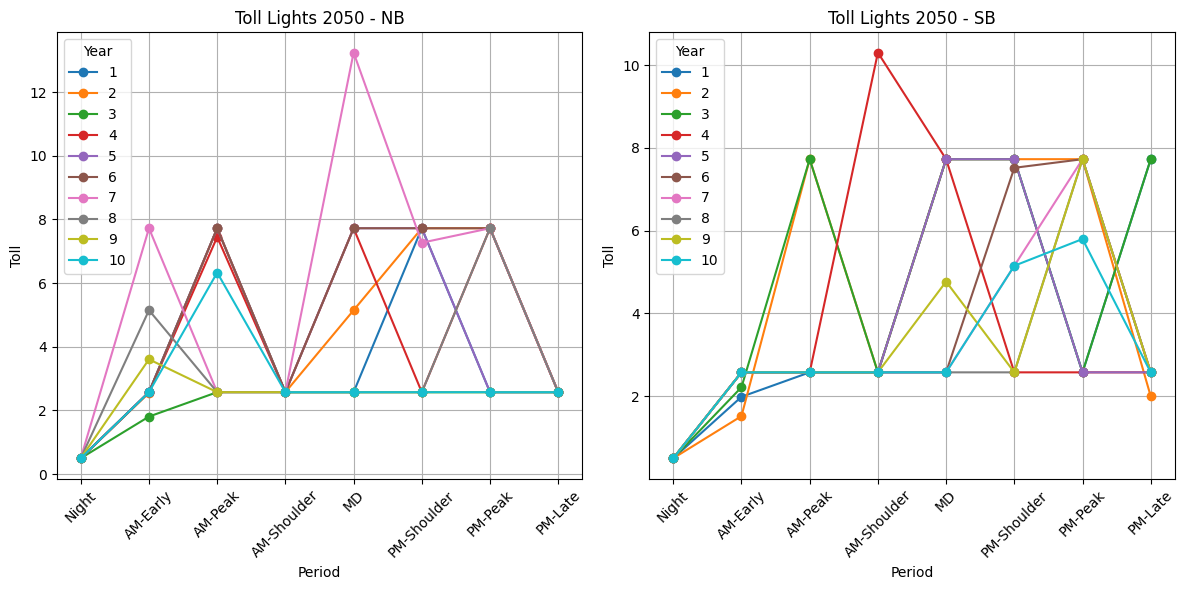

In [383]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar CSV
# model_run = pd.read_csv("outputs\\2025-09-02\\19-01-04_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

# model_run = pd.read_csv("outputs\\2025-10-02\\cap_v2\\model_run.csv")

year_val = 2050

model_run = model_run.loc[model_run["Year"] == year_val]

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5

# 2. Definir años y direcciones
segments = [1,2,3,4,5,6,7,8,9,10]
directions = ["NB", "SB"]

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    for segment in segments:
        df = model_run[(model_run["Segment"] == segment) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(segment))
        
    
    plt.title(f"Toll Lights {year_val} - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

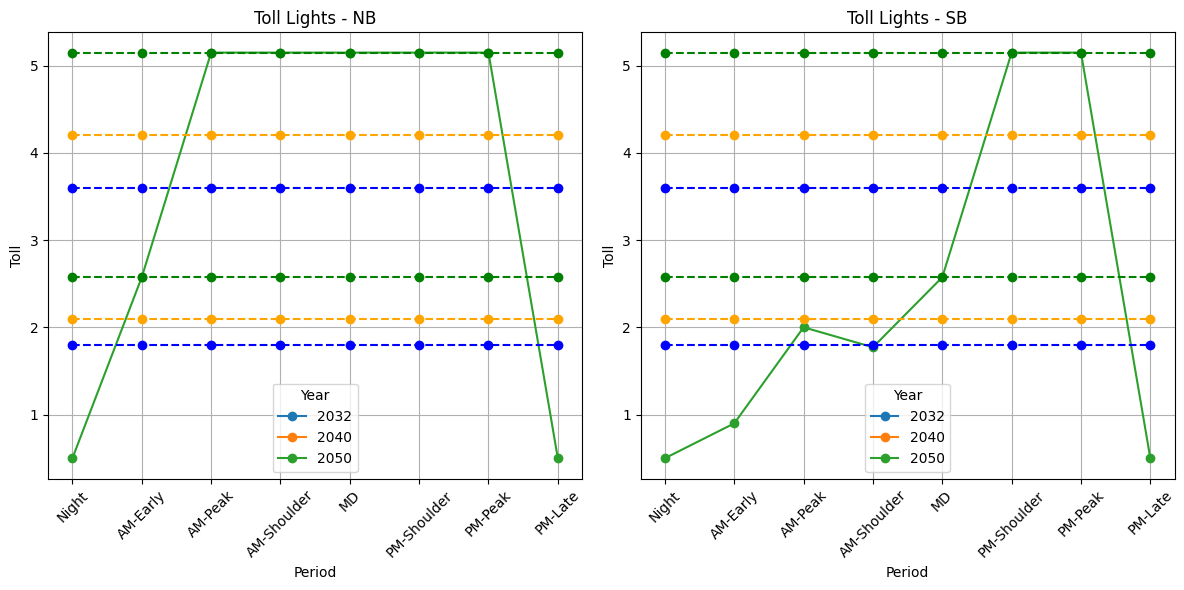

In [384]:
import pandas as pd
import matplotlib.pyplot as plt

# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-11\\total_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
model_run = pd.read_csv(f"outputs\\2025-10-08\\test_new_cap_v3\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-15\\cap_categories_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-18\\15-26-30_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-10-02\\cap_v2\\model_run.csv")

# model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

years = [2032, 2040, 2050]
directions = ["NB", "SB"]

model_run = model_run.loc[model_run["Segment"] == 2] #2

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5
model_run.loc[model_run['Period'] == 'PM-Late', 'TollLights'] = 0.5

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
        
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        #if year == 2050:
        #    df["TollLights"] = df["TollLights"].clip(upper=5.15)
        #if year == 2040:
        #    df["TollLights"] = df["TollLights"].clip(upper=4.2)
        #if year == 2032:
        #    df["TollLights"] = df["TollLights"].clip(upper=3.6)

        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(year))   
    
    
    df_cap_50 = pd.DataFrame({"Value": [5.15] * 8})
    df_cap_40 = pd.DataFrame({"Value": [4.2] * 8})
    df_cap_32 = pd.DataFrame({"Value": [3.6] * 8})
    plt.plot(df["Period"], df_cap_50["Value"], marker='o', linestyle='--', color='green') 
    plt.plot(df["Period"], df_cap_40["Value"], marker='o', linestyle='--', color='orange') 
    plt.plot(df["Period"], df_cap_32["Value"], marker='o', linestyle='--', color='blue')
    df_cap_s50 = pd.DataFrame({"Value": [5.15/2] * 8})
    df_cap_s40 = pd.DataFrame({"Value": [4.2/2] * 8})
    df_cap_s32 = pd.DataFrame({"Value": [3.6/2] * 8})
    plt.plot(df["Period"], df_cap_s50["Value"], marker='o', linestyle='--', color='green') 
    plt.plot(df["Period"], df_cap_s40["Value"], marker='o', linestyle='--', color='orange') 
    plt.plot(df["Period"], df_cap_s32["Value"], marker='o', linestyle='--', color='blue') 

    plt.title(f"Toll Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

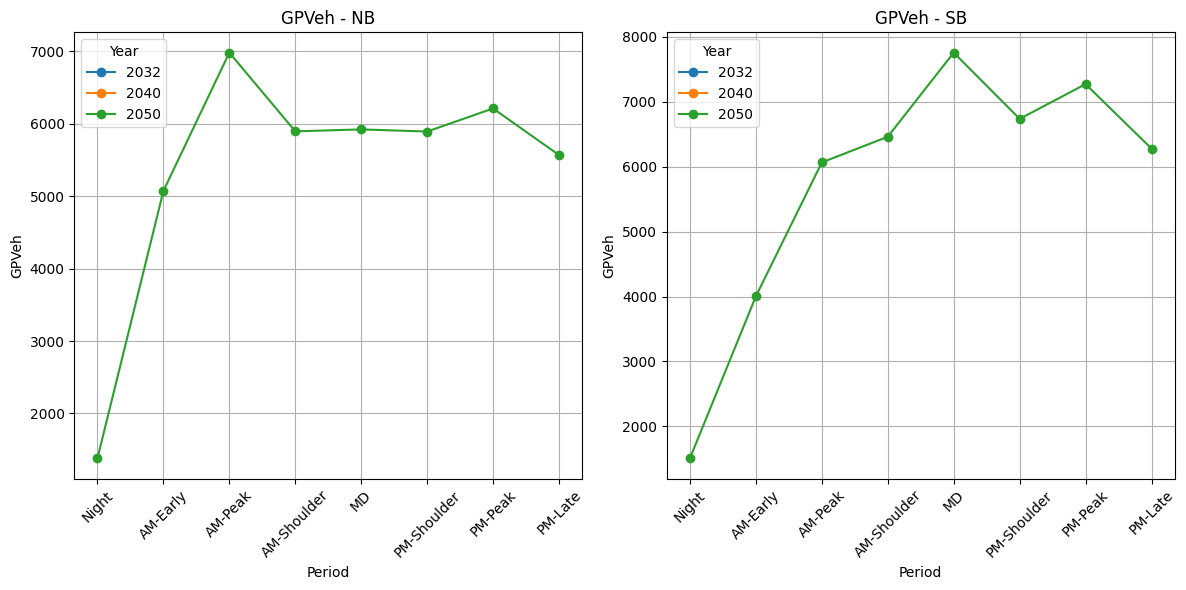

In [385]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["GPVeh"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"GPVeh - {direction}")
    plt.xlabel("Period")
    plt.ylabel("GPVeh")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

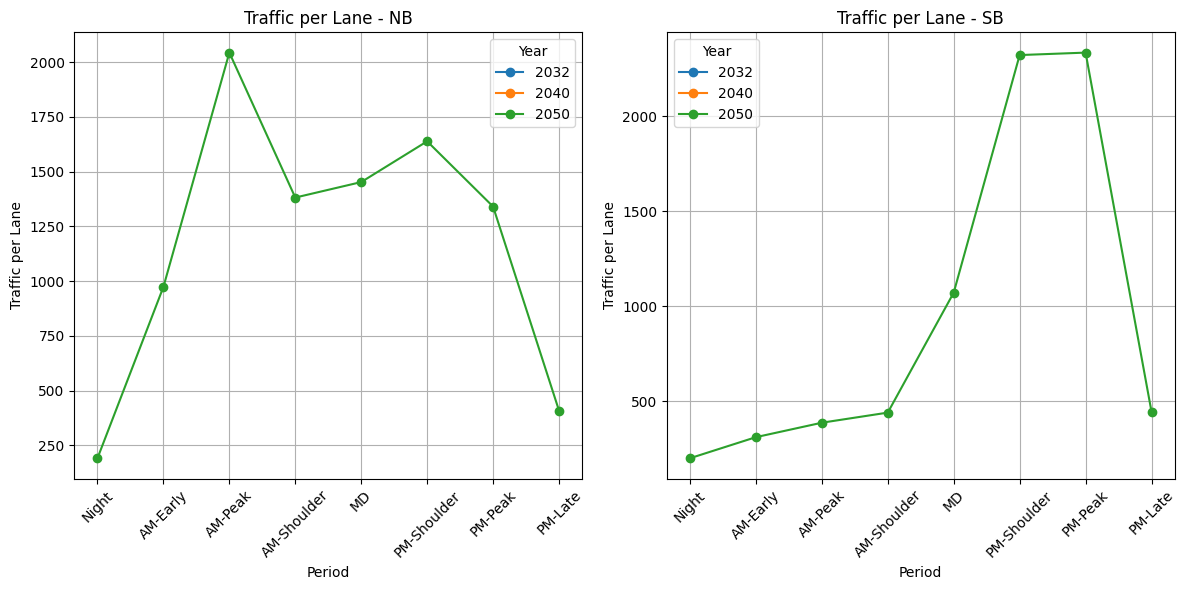

In [386]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["ML PCE"] / 2, marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Traffic per Lane - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Traffic per Lane")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

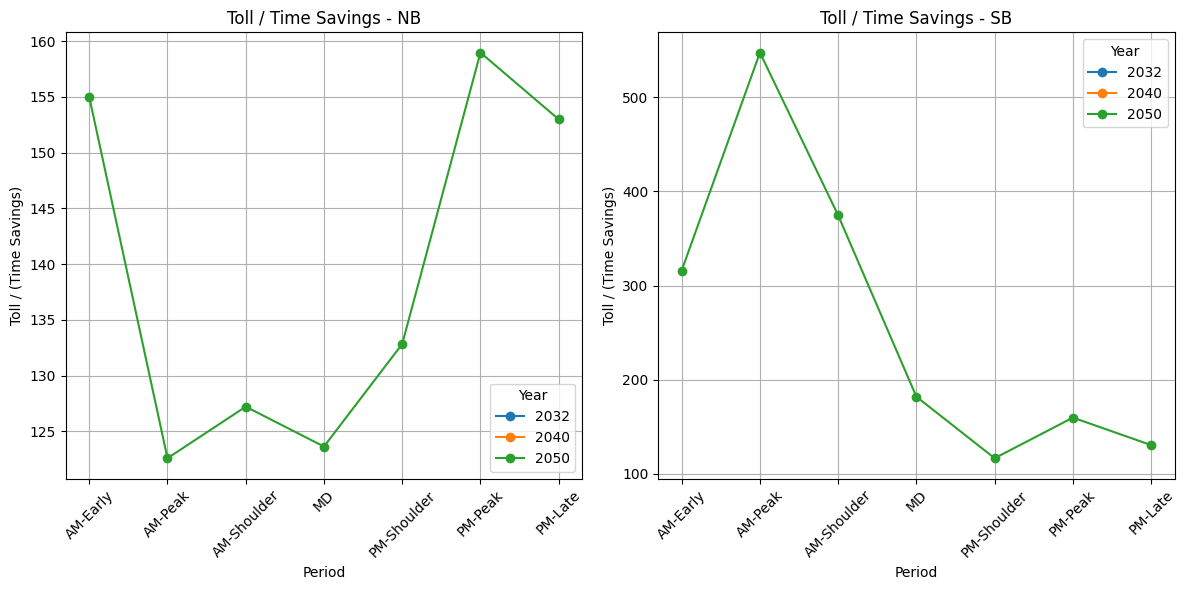

In [387]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != 'Night')]
        plt.plot(df["Period"], (60 * df["TollLights"] / (df["Time GP"] - df["Time ML"])), marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Toll / Time Savings - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll / (Time Savings)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

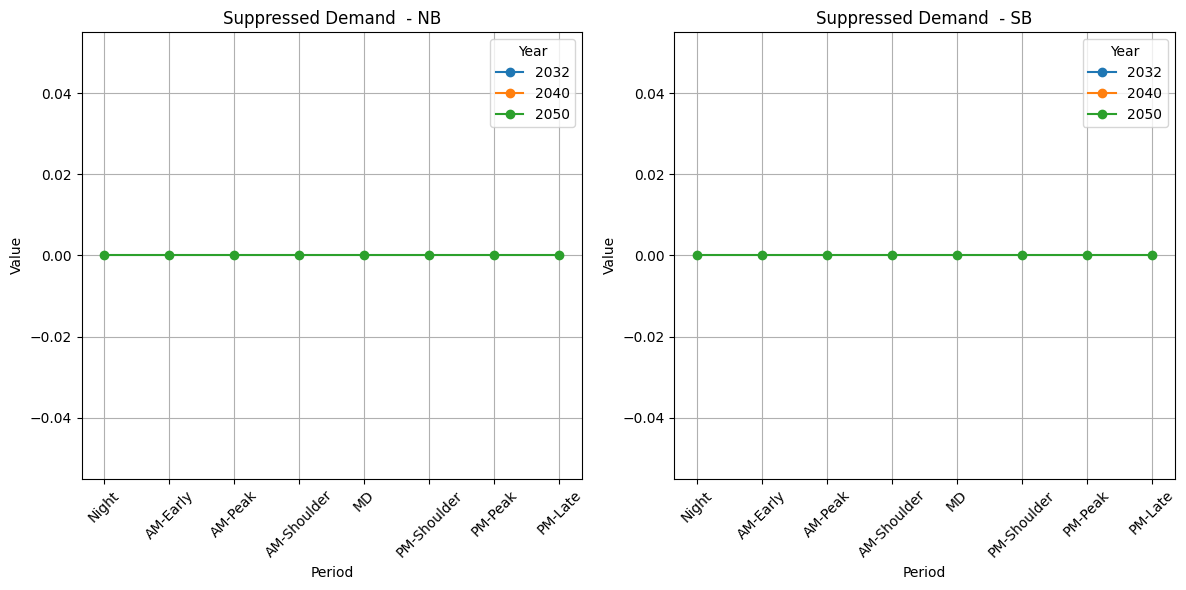

In [388]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Suppressed Demand"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Suppressed Demand  - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

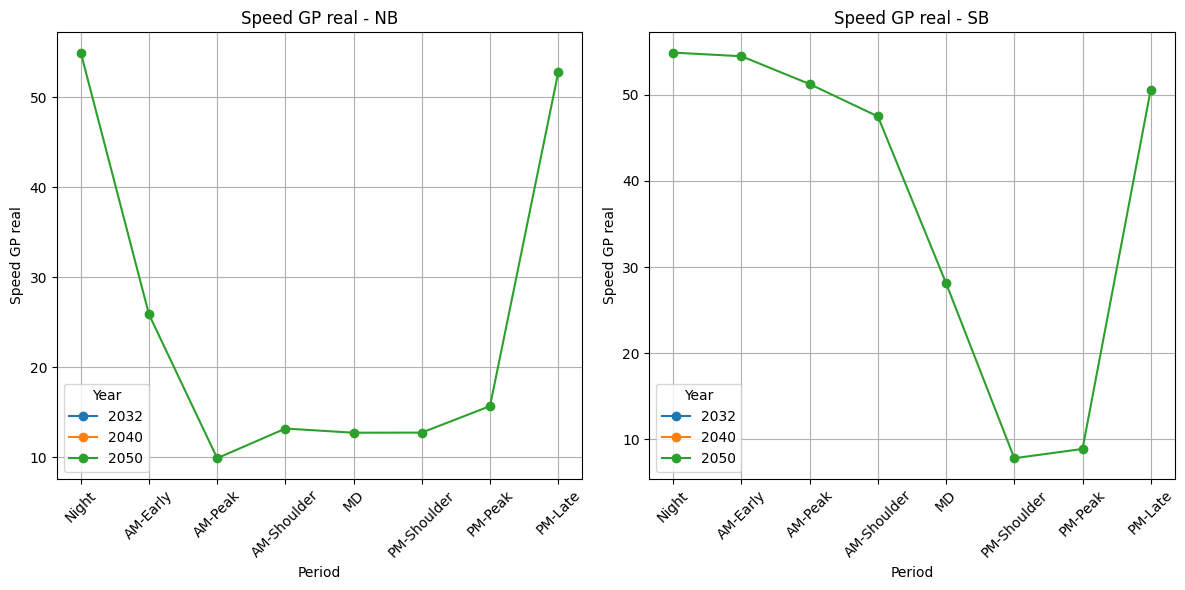

In [389]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed GP Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed GP real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed GP real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

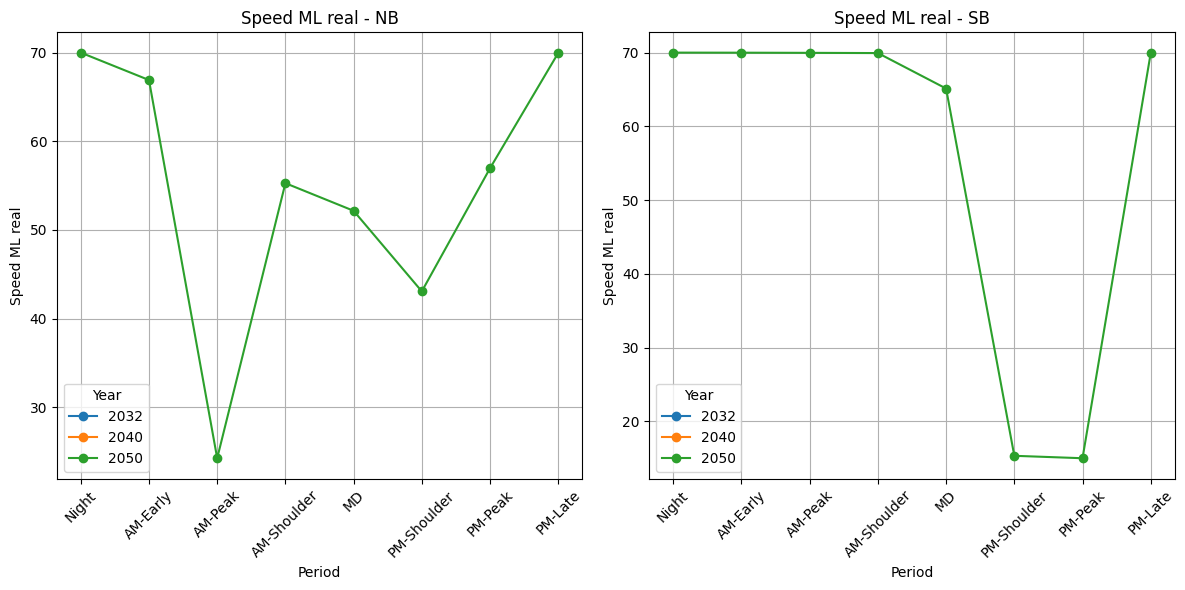

In [390]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed ML Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed ML real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed ML real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

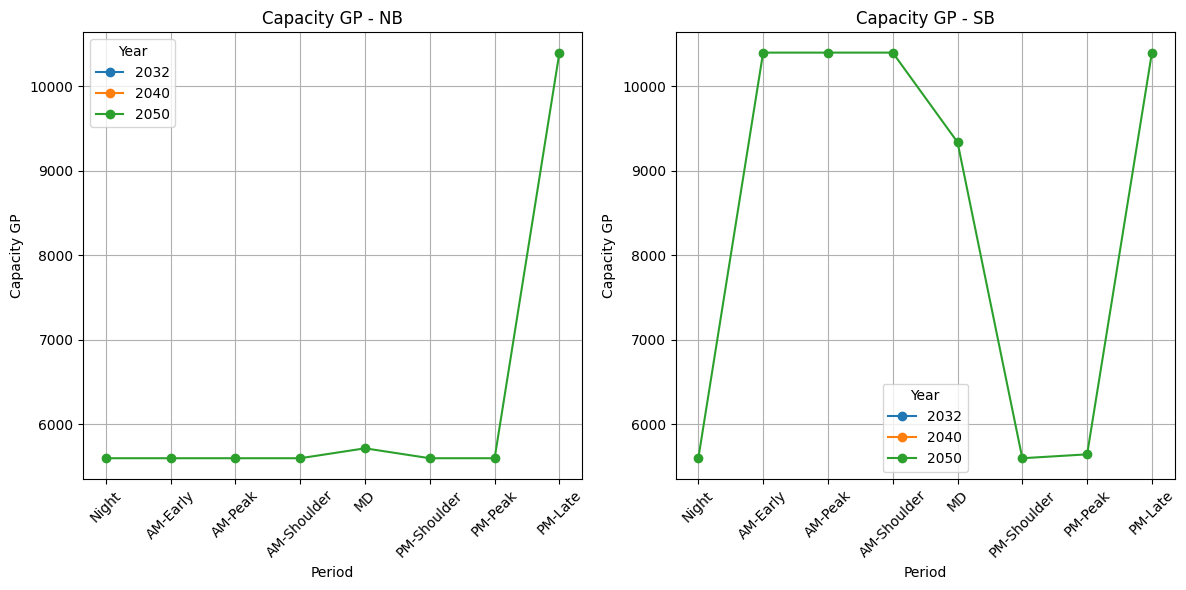

In [391]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Capacity GP"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Capacity GP - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Capacity GP")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

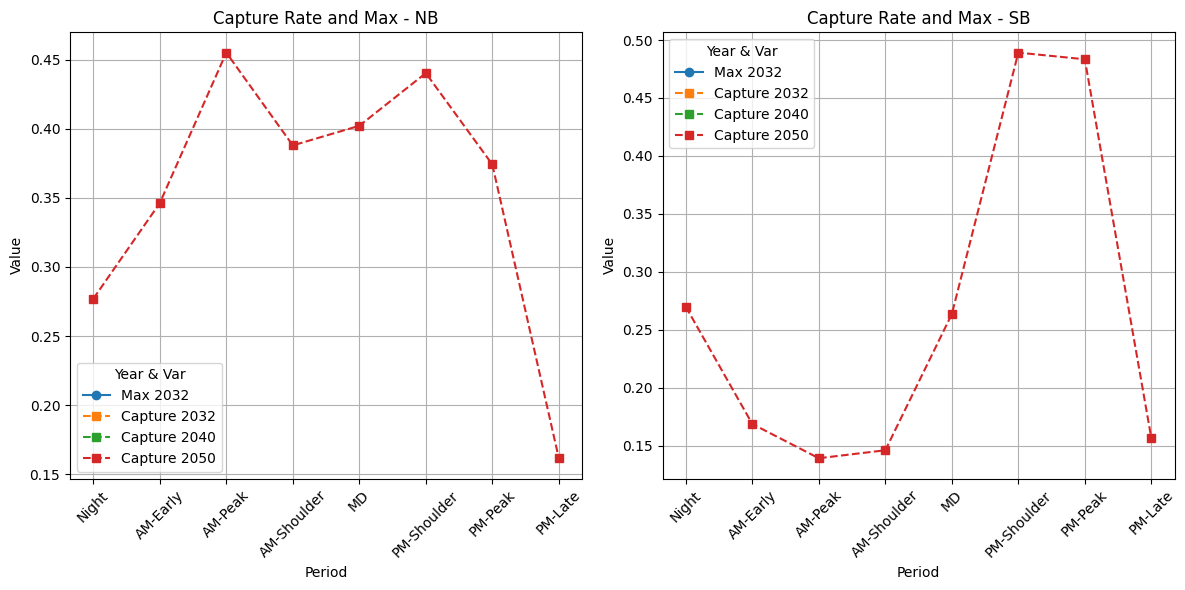

In [392]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        
        # Graficar Capture
        if year == years[0]:
            plt.plot(df["Period"], df["MaxCapture"], marker='o', linestyle='-', label=f"Max {year}")
        # Graficar Toll
        plt.plot(df["Period"], df["CaptureRateLights"], marker='s', linestyle='--', label=f"Capture {year}")
    
    plt.title(f"Capture Rate and Max - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year & Var")

plt.tight_layout()
plt.show()


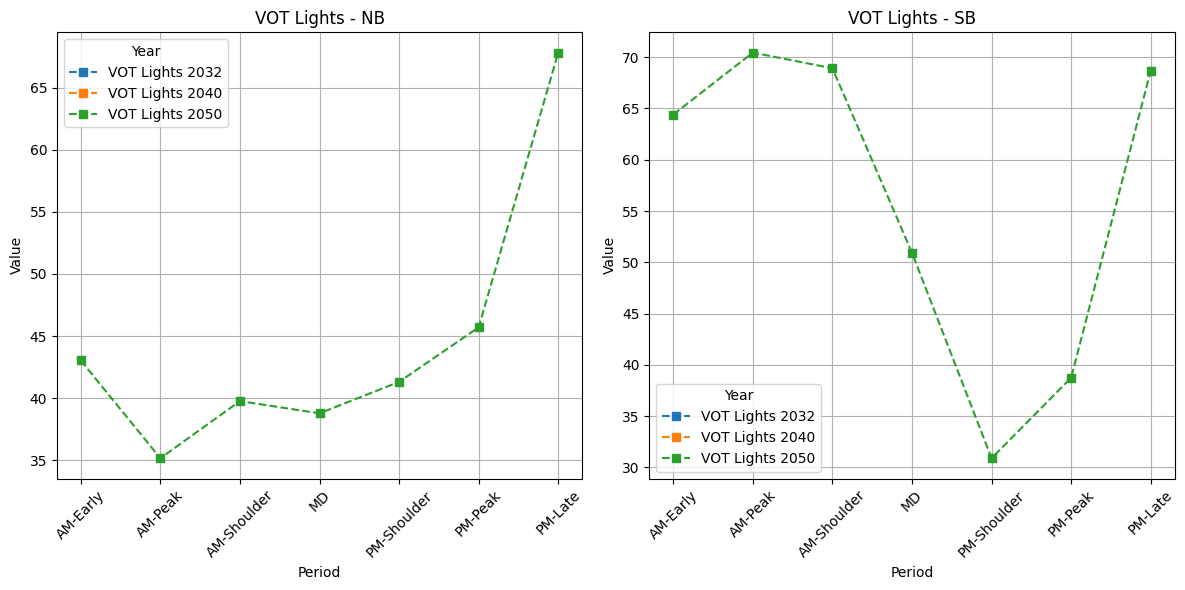

In [393]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != "Night")]

        # Graficar Toll
        plt.plot(df["Period"], df["VOT Lights"], marker='s', linestyle='--', label=f"VOT Lights {year}")
    
    plt.title(f"VOT Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()
